In [1]:
import pandas as pd
from Main import settings, features, pf_set
import time
import pickle
from pandas.tseries.offsets import DateOffset
import Prepare_Data
import data_run_files
import return_prediction_functions
from return_prediction_functions import rff
import numpy as np
from pandas.tseries.offsets import MonthEnd
from sklearn.linear_model import Ridge
import General_Functions
import pickle
import Estimate_Covariance_Matrix
import os
import prepare_portfolio_data
import portfolio_choice_functions
import scipy.linalg
import functools

start_date = pd.to_datetime('1952-12-31')

#Relevante paths
output_path = "./data_fifty/"
pickle_file_path = "./data_fifty/model_1.pkl"
wealth_path = "./data_fifty/wealth.csv"
barra_file_path = "./data_fifty/barra_cov.pkl"
output_path_market_returns = "data_fifty/market_returns_test.csv"

risk_free_path = "./data_fifty/risk_free_test.csv" 
output_data_ret_csv = "./data_fifty/data_ret.csv"  
output_data_ret_ld1_csv = "./data_fifty/data_ret_ld1.csv"

file_path_cluster_labels = "Data/Cluster Labels.csv"
file_path_factor_details = "Data/Factor Details.xlsx"

risk_free = data_run_files.process_risk_free_rate(risk_free_path, start_date)
daily_path = "./data_fifty/daily.csv"
chars_path = "./data_fifty/chars_behandlet.parquet"


Features list length: 154
Filtrering udført. Antal rækker efter filtrering: 841
Fil gemt som ./data_test/risk_free_test.csv


# Indlæser wealth, chars, daily, data_ret og data_ret_ld1

In [2]:
wealth = pd.read_csv(wealth_path)
wealth['eom'] = pd.to_datetime(wealth['eom'])
data_ret = pd.read_csv(output_data_ret_csv)
data_ret_ld1 = pd.read_csv(output_data_ret_ld1_csv)
data_ret['eom'] = pd.to_datetime(data_ret['eom'])
data_ret_ld1['eom'] = pd.to_datetime(data_ret_ld1['eom'])
data_ret_ld1['eom_ret'] = pd.to_datetime(data_ret_ld1['eom_ret'])
daily = pd.read_csv(daily_path, parse_dates=["date", "eom"])
chars = pd.read_parquet(chars_path)

Disse er checket og se ser korrekte ud wuhu :D

In [3]:
data_ret

,id,eom,ret_ld1,ret_ld2,ret_ld3,ret_ld4,ret_ld5,ret_ld6,ret_ld7,ret_ld8,ret_ld9,ret_ld10,ret_ld11,ret_ld12
0,10104,1986-04-30,-0.064934,0.031988,-0.369114,0.059902,-0.141147,0.258949,0.190520,-0.039651,0.297054,0.421617,0.137845,0.063897
1,10104,1986-05-31,0.031988,-0.369114,0.059902,-0.141147,0.258949,0.190520,-0.039651,0.297054,0.421617,0.137845,0.063897,0.155814
2,10104,1986-06-30,-0.369114,0.059902,-0.141147,0.258949,0.190520,-0.039651,0.297054,0.421617,0.137845,0.063897,0.155814,-0.188517
3,10104,1986-07-31,0.059902,-0.141147,0.258949,0.190520,-0.039651,0.297054,0.421617,0.137845,0.063897,0.155814,-0.188517,0.018414
4,10104,1986-08-31,-0.141147,0.258949,0.190520,-0.039651,0.297054,0.421617,0.137845,0.063897,0.155814,-0.188517,0.018414,0.171080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90698,92655,2022-07-31,-0.044328,-0.026268,0.096893,-0.016168,-0.032461,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
90699,92655,2022-08-31,-0.026268,0.096893,-0.016168,-0.032461,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
90700,92655,2022-09-30,0.096893,-0.016168,-0.032461,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
90701,92655,2022-10-31,-0.016168,-0.032461,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
chars

,coskew_21d,rskew_21d,ebitda_mev,dbnetis_at,at_be,market_equity,mispricing_perf,me,at_turnover,ivol_ff3_21d,...,dolvol,lambda,rvol_m,ret_ld1,eom_ret,tr_ld1,tr_ld0,mu_ld0,ff12,valid
0,0.189474,0.968421,0.117021,0.770833,0.395833,0.114583,0.312500,277.19925,0.614583,0.863158,...,5.952293e+05,3.360050e-07,0.165542,0.297054,1987-01-31,0.301954,-0.035751,-0.026385,BusEq,False
1,0.218750,0.718750,0.093750,0.770833,0.395833,0.114583,0.333333,360.69300,0.677083,0.989583,...,9.014952e+05,2.218537e-07,0.170561,0.421617,1987-02-28,0.425817,0.301954,0.129587,BusEq,False
2,0.510417,0.822917,0.083333,0.770833,0.406250,0.125000,0.385417,514.32150,0.677083,0.947917,...,1.271623e+06,1.572793e-07,0.170986,0.137845,1987-03-31,0.142145,0.425817,0.048378,BusEq,False
3,0.309278,0.319588,0.082474,0.958763,0.494845,0.154639,0.731959,587.79600,0.824742,0.969072,...,1.463353e+06,1.366724e-07,0.173280,0.063897,1987-04-30,0.068597,0.142145,0.023201,BusEq,False
4,0.489583,0.583333,0.063158,0.938144,0.494845,0.175258,0.711340,627.87300,0.824742,0.968750,...,1.892803e+06,1.056634e-07,0.174032,0.155814,1987-05-31,0.160214,0.068597,-0.016540,BusEq,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73211,0.650000,0.827778,0.183908,0.466667,0.461078,0.983333,0.933333,508808.22768,0.911111,0.600000,...,1.633418e+09,1.224426e-10,0.069191,-0.044328,2022-08-31,-0.043528,0.055684,0.093630,Money,True
73212,0.566667,0.566667,0.201149,0.461111,0.455090,0.983333,0.927778,485772.46938,0.911111,0.255556,...,1.558158e+09,1.283567e-10,0.068704,-0.026268,2022-09-30,-0.024368,-0.043528,-0.036188,Money,True
73213,0.066667,0.344444,0.149425,0.450000,0.451807,0.983333,0.944444,472405.83831,0.911111,0.383333,...,1.516174e+09,1.319110e-10,0.068843,0.096893,2022-10-31,0.098793,-0.024368,-0.091370,Money,True
73214,0.305556,0.105556,0.189655,0.561111,0.475904,0.983333,0.916667,519277.89529,0.911111,0.094444,...,1.494588e+09,1.338161e-10,0.068225,-0.016168,2022-11-30,-0.013868,0.098793,0.081350,Money,True


In [4]:
X_features = chars[features].values

In [7]:
print(X_features.shape)
print(X_features)

(73216, 115)
[[0.015625   0.97260274 0.5        ... 0.69791667 0.46875    0.98958333]
 [0.015625   0.98630137 0.5        ... 0.09375    0.35416667 0.97916667]
 [0.015625   0.98630137 0.5        ... 0.13541667 0.29166667 0.97916667]
 ...
 [0.40555556 0.33333333 0.4        ... 0.93333333 0.90555556 0.2       ]
 [0.40555556 0.35151515 0.36774194 ... 0.91666667 0.91111111 0.15      ]
 [0.40555556 0.35151515 0.35483871 ... 0.77777778 0.90555556 0.17777778]]


## Hent Predictions :D

### Indlæsning af Pickle fil (predictions)

In [5]:
with open(pickle_file_path, "rb") as file:
    model_1 = pickle.load(file)

#print(model_1) #Vi bruger dog ikke ikke denne i selve 

# Barra COV

Just a quick check

In [6]:
with open(barra_file_path, "rb") as file:
    barra_cov = pickle.load(file)

In [7]:
print(barra_cov['2022-11-30']['ivol_vec'])

id
10104    0.004043
10107    0.002393
10138    0.002996
10696    0.003696
11308    0.001280
           ...   
87299    0.004106
87432    0.003534
87447    0.003139
87717    0.003166
92655    0.002555
Name: res_vol, Length: 180, dtype: float64


# Prepare Portfolio Data - tilføj return predictions, lambda list og datoer

In [8]:
chars = prepare_portfolio_data.add_return_predictions(chars,settings, output_path)

In [9]:
print(chars.shape) #Skal være 73216 x 131
print(chars[['id', 'eom','pred_ld1']])

(73216, 131)
          id        eom  pred_ld1
0      10104 1986-12-31       NaN
1      10104 1987-01-31       NaN
2      10104 1987-02-28       NaN
3      10104 1987-03-31       NaN
4      10104 1987-04-30       NaN
...      ...        ...       ...
73211  92655 2022-07-31  0.010957
73212  92655 2022-08-31  0.009506
73213  92655 2022-09-30  0.010641
73214  92655 2022-10-31  0.010774
73215  92655 2022-11-30  0.011608

[73216 rows x 3 columns]


In [10]:
lambda_list = prepare_portfolio_data.create_lambda_list(chars)

In [11]:
first_cov_date, hp_years, start_oos = prepare_portfolio_data.define_important_dates(barra_cov, settings)
date_ranges = prepare_portfolio_data.create_date_ranges(settings, first_cov_date, start_oos, hp_years)
dates_m1 = date_ranges["dates_m1"]
dates_m2 = date_ranges["dates_m2"]
dates_oos = date_ranges["dates_oos"]
dates_hp = date_ranges["dates_hp"]
#Disse er alle korrekte

# Base cases

In [12]:
print(wealth['eom'])
print(dates_oos)
print(pf_set)

0     1952-11-30
1     1952-12-31
2     1953-01-31
3     1953-02-28
4     1953-03-31
         ...    
837   2022-08-31
838   2022-09-30
839   2022-10-31
840   2022-11-30
841   2022-12-31
Name: eom, Length: 842, dtype: datetime64[ns]
DatetimeIndex(['2010-12-31', '2011-01-31', '2011-02-28', '2011-03-31',
               '2011-04-30', '2011-05-31', '2011-06-30', '2011-07-31',
               '2011-08-31', '2011-09-30',
               ...
               '2022-02-28', '2022-03-31', '2022-04-30', '2022-05-31',
               '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30',
               '2022-10-31', '2022-11-30'],
              dtype='datetime64[ns]', length=144, freq='ME')
{'wealth': 10000000000.0, 'gamma_rel': 10, 'mu': 0.007, 'lb_hor': 11}


In [13]:
ew = portfolio_choice_functions.ew_implement(data=chars, wealth=wealth, dates=dates_oos, pf_set=pf_set)
mkt = portfolio_choice_functions.mkt_implement(data=chars, wealth=wealth, dates=dates_oos, pf_set= pf_set)
rw = portfolio_choice_functions.rw_implement(data=chars, wealth=wealth, dates=dates_oos, pf_set= pf_set)
mv = portfolio_choice_functions.mv_implement(data=chars, cov_list=barra_cov ,wealth=wealth, dates=dates_oos, pf_set= pf_set)
factor_ml = portfolio_choice_functions.factor_ml_implement(data = chars, wealth = wealth, dates= dates_oos, n_pfs=settings["factor_ml"]["n_pfs"]
, gam=pf_set['gamma_rel'])
tpf = portfolio_choice_functions.tpf_implement(data=chars, cov_list=barra_cov, wealth=wealth, dates=dates_oos, gam=pf_set["gamma_rel"])

# STATIC ML

In [ ]:
General_Functions

In [14]:
def create_lambda(x, ids):
    return np.diag([x[i] for i in ids])


In [241]:
import itertools


def static_val_fun(data, dates, cov_list, lambda_list, wealth, cov_type, gamma_rel, k=None, g=None, u=None, hps=None):
    """
    Beregner de statiske vægte for de angivne datoer.
    Parametre:
      - data: DataFrame med portefølje-data.
      - dates: Liste af datoer (som datetime-objekter).
      - cov_list: Dictionary med covariance-data pr. dato.
      - lambda_list: Dictionary med lambda-data pr. dato.
      - wealth: DataFrame med wealth-information (skal indeholde 'eom' og 'wealth', evt. 'mu_ld1').
      - cov_type: Type til justering af covariance.
      - gamma_rel: Skalar til vægtning.
      - k, g, u: Parametre, kan angives direkte.
      - hps: DataFrame med hyperparametre; hvis angivet, opdateres k, g og u for hver dato.
    """
    # Start med initiale weights (f.eks. VW, alt efter initial_weights_new)
    static_weights = General_Functions.initial_weights_new(data, w_type="vw")
    
    # Merge med kolonner fra data: id, eom, tr_ld1 og pred_ld1
    static_weights = static_weights.merge(data[['id', 'eom', 'tr_ld1', 'pred_ld1']], on=['id', 'eom'], how='left')
    # Merge med wealth for at få mu_ld1
    static_weights = static_weights.merge(wealth[['eom', 'mu_ld1']], on='eom', how='left')
    
    for d in dates:
        # Hvis hyperparametre (hps) er angivet, så opdater k, g og u
        if hps is not None:
            # Filtrer rækker hvor året for eom_ret er mindre end året for d
            hp_candidates = hps[hps['eom_ret'].dt.year < d.year]
            if not hp_candidates.empty:
                # Vælg den række med den seneste eom_ret
                hp = hp_candidates.loc[hp_candidates['eom_ret'].idxmax()]
                g = hp['g']
                u = hp['u']
                k = hp['k']
        
        # Hent wealth for datoen
        wealth_t_series = wealth.loc[wealth['eom'] == d, 'wealth']
        if wealth_t_series.empty:
            continue  # Eller håndtér fejlen, hvis der mangler data for d
        wealth_t = wealth_t_series.iloc[0]
        
        # Vælg de rækker i static_weights for datoen d
        mask = static_weights['eom'] == d
        # Sørg for, at id'erne er strenge (for at matche med de oprettede matricer)
        ids = static_weights.loc[mask, 'id'].tolist()

        
        # Byg covariance matrix og tilpas den
        sigma_gam = General_Functions.create_cov(cov_list[d], ids=ids) * gamma_rel

        sigma_gam = General_Functions.sigma_gam_adj(sigma_gam, g=g, cov_type=cov_type)
        
        # Byg lambda matrix og skaler med k
        lambda_val = create_lambda(lambda_list[d], ids=ids)
        lambda_val = lambda_val * k
        
        # Ekstraher de nødvendige kolonner som numpy-arrays
        pred_ld1 = static_weights.loc[mask, 'pred_ld1'].values
        w_start = static_weights.loc[mask, 'w_start'].values
        
        # Beregn højresidevektoren: pred_ld1 * u + wealth_t * (lambda @ w_start)
        rhs = (pred_ld1 * u) + wealth_t * (lambda_val.dot(w_start))
        # Matrix A: sigma_gam + wealth_t * lambda
        A = sigma_gam + wealth_t * lambda_val
        # Løs lineært system for at få nye vægte
        w_new = np.linalg.solve(A, rhs)
        # Tildel de beregnede vægte til kolonnen 'w' for de relevante rækker
        static_weights.loc[mask, 'w'] = w_new
        
        # Opdater startvægt for næste måned:
        try:
            current_index = list(dates).index(d)
            next_month = dates[current_index + 1]
        except IndexError:
            # Hvis der ikke er nogen næste dato, springes opdateringen over
            continue
        
        # Udregn 'w_opt_lag1' for de rækker, der svarer til d, men til næste måned
        temp = static_weights.loc[mask, ['id', 'w', 'tr_ld1', 'mu_ld1']].copy()
        temp['eom'] = next_month
        temp['w_opt_lag1'] = temp['w'] * (1 + temp['tr_ld1']) / (1 + temp['mu_ld1'])
        
        # Merge temp med static_weights på ['id', 'eom']
        static_weights = static_weights.merge(temp[['id', 'eom', 'w_opt_lag1']], on=['id', 'eom'], how='left')
        
        # Sæt w_start for rækker med eom == next_month
        next_mask = static_weights['eom'] == next_month
        static_weights.loc[next_mask, 'w_start'] = static_weights.loc[next_mask, 'w_opt_lag1']
        static_weights.loc[next_mask & static_weights['w_start'].isna(), 'w_start'] = 0
        
        # Fjern den midlertidige kolonne
        static_weights.drop(columns='w_opt_lag1', inplace=True)
        
    return static_weights


In [16]:
def static_implement(data_tc, cov_list, lambda_list, rf, wealth, mu, gamma_rel,
                     dates_full, dates_oos, dates_hp, hp_years,
                     k_vec, u_vec, g_vec, cov_type, validation=None, seed=None):
    """
    Fuldt statisk implementering.
    Parametre:
      - data_tc: DataFrame med tidsserie-data.
      - cov_list, lambda_list: Ordbøger med covariance- og lambda-data.
      - rf, wealth, mu, gamma_rel: Diverse parametre.
      - dates_full, dates_oos, dates_hp: Lister af datoer (skal være datetime-objekter).
      - hp_years: Årstal for HP-valg.
      - k_vec, u_vec, g_vec: Vektorer med hyperparametre.
      - cov_type: Typen af covariance.
      - validation: Valideringsresultater (kan være None, hvorefter de udregnes).
      - seed: Til eventuel reproducibilitet.
    """
    # Konverter nøglerne i cov_list og lambda_list til pd.Timestamp
    cov_list = {pd.to_datetime(key): value for key, value in cov_list.items()}
    lambda_list = {pd.to_datetime(key): value for key, value in lambda_list.items()}
    
    # Opret HP-grid: alle kombinationer af k, u og g
    static_hps = pd.DataFrame(list(itertools.product(k_vec, u_vec, g_vec)), columns=['k', 'u', 'g'])
    
    # Udvælg relevant data: valid == True og eom i dates_hp, med kolonnerne id, eom, me, tr_ld1, pred_ld1, sorteret efter id og eom
    data_rel = data_tc[(data_tc['valid'] == True) & (data_tc['eom'].isin(dates_hp))][['id', 'eom', 'me', 'tr_ld1', 'pred_ld1']]
    data_rel = data_rel.sort_values(by=['id', 'eom'])
    
    # Hvis der ikke allerede er beregnet validation, udregnes den
    if validation is None:
        validation_list = []
        for i in range(len(static_hps)):
            print(i)
            hp = static_hps.iloc[i]
            static_w = static_val_fun(
                data_rel,
                dates=dates_hp,
                cov_list=cov_list,
                lambda_list=lambda_list,
                wealth=wealth,
                gamma_rel=gamma_rel,
                k=hp['k'],
                g=hp['g'],
                u=hp['u'],
                cov_type=cov_type
            )
            # Anvend pf_ts_fun på resultatet – denne funktion skal returnere en DataFrame med bl.a. 'eom_ret', 'r' og 'tc'
            static_w_pf = General_Functions.pf_ts_fun(static_w, data=data_tc, wealth=wealth, gam=gamma_rel)
            static_w_pf['hp_no'] = i
            static_w_pf['k'] = hp['k']
            static_w_pf['g'] = hp['g']
            static_w_pf['u'] = hp['u']
            validation_list.append(static_w_pf)
        validation = pd.concat(validation_list, ignore_index=True)
    
    # Sortér validation på hp_no og eom_ret
    validation.sort_values(by=['hp_no', 'eom_ret'], inplace=True)
    
    # Beregn kumulative middelværdier (cummean) per hp_no
    validation['cum_mean_r2'] = validation.groupby('hp_no')['r'].transform(lambda x: x.pow(2).expanding().mean())
    validation['cum_mean_r']  = validation.groupby('hp_no')['r'].transform(lambda x: x.expanding().mean())
    validation['cum_var'] = validation['cum_mean_r2'] - validation['cum_mean_r'] ** 2
    
    # Beregn cum_obj for hver hp_no: cummean(r - tc - 0.5 * cum_var * gamma_rel)
    def compute_cum_obj(group):
        return (group['r'] - group['tc'] - 0.5 * group['cum_var'] * gamma_rel).expanding().mean()
    
    validation['cum_obj'] = validation.groupby('hp_no', group_keys=False).apply(compute_cum_obj)
    
    # Beregn rangering inden for hver eom_ret-gruppe baseret på -cum_obj
    validation['rank'] = validation.groupby('eom_ret')['cum_obj'].rank(ascending=False, method='first')
    
    # Vælg de optimale HP'er: de rækker hvor eom_ret har måned == 12 og rank == 1, sorteret efter eom_ret
    optimal_hps = validation[(validation['eom_ret'].dt.month == 12) & (validation['rank'] == 1)].sort_values(by='eom_ret')
    
    # Implementér den endelige portefølje: vælg data_tc hvor eom i dates_oos og valid == True
    w_data = data_tc[(data_tc['eom'].isin(dates_oos)) & (data_tc['valid'] == True)][['id', 'eom', 'me', 'tr_ld1', 'pred_ld1']]
    w = static_val_fun(
        w_data,
        dates=dates_oos,
        cov_list=cov_list,
        lambda_list=lambda_list,
        wealth=wealth,
        gamma_rel=gamma_rel,
        hps=optimal_hps,
        cov_type=cov_type
    )
    
    pf = General_Functions.pf_ts_fun(w, data=data_tc, wealth=wealth, gam=gamma_rel)
    pf['type'] = "Static-ML*"
    
    return {"hps": validation, "best_hps": optimal_hps, "w": w, "pf": pf}


In [17]:
static = static_implement(
    data_tc=chars,
    cov_list=barra_cov,
    lambda_list=lambda_list,
    rf=risk_free,              # Data
    wealth=wealth,
    mu=pf_set['mu'],
    gamma_rel=pf_set['gamma_rel'],  # Investor
    dates_full=dates_m1,
    dates_oos=dates_oos,
    dates_hp=dates_hp,
    hp_years=hp_years,          # Dates
    k_vec=settings['pf']['hps']['static']['k'],
    u_vec=settings['pf']['hps']['static']['u'],
    g_vec=settings['pf']['hps']['static']['g'],
    cov_type=settings['pf']['hps']['cov_type'],
    validation=None
)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


C:\Users\andre\AppData\Local\Temp\ipykernel_24440\3287424247.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [18]:
output_path_static = "./data_fifty/static.pkl"  # eller f.eks. "C:/min/mappe/static.pkl"
with open(output_path_static, "wb") as f:
    pickle.dump(static, f)

In [19]:
static["pf"]

,inv,shorting,turnover,r,tc,eom_ret,type
0,0.551666,0.079743,0.607821,0.004094,0.001498,2011-01-31,Static-ML*
1,0.511579,0.113264,0.110400,0.014675,0.000067,2011-02-28,Static-ML*
2,0.484590,0.115088,0.059014,0.005892,0.000020,2011-03-31,Static-ML*
3,0.476945,0.115082,0.038720,0.013924,0.000009,2011-04-30,Static-ML*
4,0.478102,0.113065,0.033812,0.001798,0.000008,2011-05-31,Static-ML*
...,...,...,...,...,...,...,...
139,0.945114,0.270844,0.043515,-0.011592,0.000026,2022-08-31,Static-ML*
140,0.943065,0.275193,0.044319,-0.027664,0.000025,2022-09-30,Static-ML*
141,0.942891,0.275907,0.041501,0.040588,0.000023,2022-10-31,Static-ML*
142,0.954800,0.280026,0.036990,0.023830,0.000022,2022-11-30,Static-ML*


In [18]:
static["hps"]

,inv,shorting,turnover,r,tc,eom_ret,hp_no,k,g,u,cum_mean_r2,cum_mean_r,cum_var,cum_obj,rank
0,0.569087,0.022263,0.483848,-0.006528,0.001461,2001-01-31,0,1.0,0.0,0.25,0.000043,-0.006528,0.000000e+00,-0.007989,25.0
1,0.457976,0.054599,0.215799,-0.004249,0.000322,2001-02-28,0,1.0,0.0,0.25,0.000030,-0.005389,1.298779e-06,-0.006283,17.0
2,0.447034,0.067469,0.170632,-0.005693,0.000200,2001-03-31,0,1.0,0.0,0.25,0.000031,-0.005490,8.864646e-07,-0.006155,9.0
3,0.464901,0.082075,0.160113,0.021935,0.000160,2001-04-30,0,1.0,0.0,0.25,0.000144,0.001366,1.416909e-04,0.000651,24.0
4,0.496974,0.107694,0.145025,0.002751,0.000140,2001-05-31,0,1.0,0.0,0.25,0.000116,0.001643,1.136596e-04,0.000929,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7123,1.624196,0.447748,0.212894,-0.017031,0.000692,2022-08-31,26,0.2,2.0,1.00,0.001212,0.010520,1.100894e-03,-0.004032,22.0
7124,1.642989,0.469470,0.220085,-0.059857,0.000727,2022-09-30,26,0.2,2.0,1.00,0.001221,0.010250,1.115581e-03,-0.004270,22.0
7125,1.655115,0.478227,0.196233,0.071438,0.000702,2022-10-31,26,0.2,2.0,1.00,0.001235,0.010484,1.125558e-03,-0.004005,22.0
7126,1.686589,0.489138,0.188407,0.044224,0.000676,2022-11-30,26,0.2,2.0,1.00,0.001238,0.010612,1.125590e-03,-0.003845,22.0


In [20]:


# Sti til din base-mappe
base_path = "./data_fifty/"
# Hent liste over undermapper/filer


# Saml porteføljerne i én DataFrame inklusiv Static-ML
bm_pfs = pd.concat(
    [tpf["pf"], factor_ml["pf"], ew["pf"], mkt["pf"], rw["pf"], mv["pf"], static["pf"]], 
    ignore_index=True
)

# Gem resultatet som CSV
bm_pfs.to_csv(f"{output_path}/bms.csv", index=False)

# Læs CSV-filen med pandas
bm_pfs = pd.read_csv(os.path.join(base_path, "bms.csv"))

# Konverter eom_ret til dato
bm_pfs['eom_ret'] = pd.to_datetime(bm_pfs['eom_ret'])

# Erstat "Rank-Weighted" med "Rank-ML" i kolonnen type
bm_pfs.loc[bm_pfs['type'] == 'Rank-Weighted', 'type'] = 'Rank-ML'

pfs = bm_pfs


In [21]:
pfs

,inv,shorting,turnover,r,tc,eom_ret,type
0,2.348589,0.892175,2.781951,-0.005601,0.110822,2011-01-31,Markowitz-ML
1,2.238954,0.835469,1.249702,0.034830,0.030633,2011-02-28,Markowitz-ML
2,2.228725,0.835082,1.118005,0.015015,0.030967,2011-03-31,Markowitz-ML
3,2.316815,0.868654,1.203534,0.038226,0.022344,2011-04-30,Markowitz-ML
4,2.304745,0.861032,1.624950,0.010121,0.049307,2011-05-31,Markowitz-ML
...,...,...,...,...,...,...,...
1003,0.945114,0.270844,0.043515,-0.011592,0.000026,2022-08-31,Static-ML*
1004,0.943065,0.275193,0.044319,-0.027664,0.000025,2022-09-30,Static-ML*
1005,0.942891,0.275907,0.041501,0.040588,0.000023,2022-10-31,Static-ML*
1006,0.954800,0.280026,0.036990,0.023830,0.000022,2022-11-30,Static-ML*


In [22]:
static_ml_star = pfs[pfs['type'] == "Static-ML*"]
static_ml_star

,inv,shorting,turnover,r,tc,eom_ret,type
864,0.551666,0.079743,0.607821,0.004094,0.001498,2011-01-31,Static-ML*
865,0.511579,0.113264,0.110400,0.014675,0.000067,2011-02-28,Static-ML*
866,0.484590,0.115088,0.059014,0.005892,0.000020,2011-03-31,Static-ML*
867,0.476945,0.115082,0.038720,0.013924,0.000009,2011-04-30,Static-ML*
868,0.478102,0.113065,0.033812,0.001798,0.000008,2011-05-31,Static-ML*
...,...,...,...,...,...,...,...
1003,0.945114,0.270844,0.043515,-0.011592,0.000026,2022-08-31,Static-ML*
1004,0.943065,0.275193,0.044319,-0.027664,0.000025,2022-09-30,Static-ML*
1005,0.942891,0.275907,0.041501,0.040588,0.000023,2022-10-31,Static-ML*
1006,0.954800,0.280026,0.036990,0.023830,0.000022,2022-11-30,Static-ML*


In [23]:
pfs = bm_pfs



In [24]:
subset_hps = static["hps"][
    static["hps"]["eom_ret"].isin(static["pf"]["eom_ret"]) &
    (static["hps"]["k"] == 1) &
    (static["hps"]["g"] == 0) &
    (static["hps"]["u"] == 1)
].copy()

subset_hps["eom_ret"] = pd.to_datetime(subset_hps["eom_ret"])
subset_hps = subset_hps[["eom_ret", "inv", "shorting", "turnover", "r", "tc"]]
subset_hps["type"] = "Static-ML"

pfs = pd.concat([   # Static-ML portefølje-tidsserie
    bm_pfs,         # Benchmark-porteføljer
    subset_hps      # Filtreret subset af static["hps"]
], ignore_index=True)

In [25]:
# Antag at 'static' er en dictionary med dataframes under nøglerne "pf" og "hps", 
# og at bm_pfs også er en pandas DataFrame.

# Filtrer static["hps"] efter de ønskede kriterier
subset_hps = static["hps"][
    static["hps"]["eom_ret"].isin(static["pf"]["eom_ret"]) &
    (static["hps"]["k"] == 1) &
    (static["hps"]["g"] == 0) &
    (static["hps"]["u"] == 1)
].copy()

# Sørg for at 'eom_ret' er datetime (hvis ikke allerede)
subset_hps["eom_ret"] = pd.to_datetime(subset_hps["eom_ret"])

# Vælg de ønskede kolonner
subset_hps = subset_hps[["eom_ret", "inv", "shorting", "turnover", "r", "tc"]]

# Tilføj en kolonne 'type' med værdien "Static-ML"
subset_hps["type"] = "Static-ML"

# Kombinér de tre dataframes med pd.concat (svarer til rbind i R)
pfs = pd.concat([
    bm_pfs,         # Benchmark-porteføljer
    subset_hps      # Filtreret subset af static["hps"]
], ignore_index=True)

pf_order = [
    # "Portfolio-ML",  # denne er kommenteret ud som i R-koden
    "Static-ML",
    "Static-ML*",
    "Markowitz-ML",
    "Factor-ML",
    "Rank-ML",
    "Minimum Variance",
    "1/N",
    "Market"
]



In [26]:
subset_hps

,eom_ret,inv,shorting,turnover,r,tc,type
1704,2011-01-31,3.368615,1.414875,0.085699,-0.035320,0.000056,Static-ML
1705,2011-02-28,3.311750,1.398927,0.112134,0.047406,0.000081,Static-ML
1706,2011-03-31,3.323827,1.431866,0.141992,0.030237,0.000141,Static-ML
1707,2011-04-30,3.320241,1.413587,0.081797,0.051697,0.000052,Static-ML
1708,2011-05-31,3.318759,1.393471,0.113333,0.009124,0.000083,Static-ML
...,...,...,...,...,...,...,...
1843,2022-08-31,3.821866,1.462927,0.117163,-0.035054,0.000177,Static-ML
1844,2022-09-30,3.819133,1.479542,0.106897,-0.049943,0.000155,Static-ML
1845,2022-10-31,3.799222,1.465767,0.105471,0.111330,0.000145,Static-ML
1846,2022-11-30,3.839316,1.472189,0.104272,0.049934,0.000152,Static-ML


In [27]:
pfs["type"].unique()

array(['Markowitz-ML', 'Factor-ML', '1/N', 'Market', 'Rank-ML',
       'Minimum Variance', 'Static-ML*', 'Static-ML'], dtype=object)

In [28]:
main_types = pf_order

# 3) Tildel factor-rækkefølgen og sorter
pfs['type'] = pd.Categorical(pfs['type'], categories=pf_order, ordered=True)
pfs = pfs.sort_values(by=['type', 'eom_ret'])

pfs['e_var_adj'] = pfs.groupby('type')['r'].transform(lambda x: (x - x.mean())**2)

# Beregn utility_t: r - tc - 0.5 * e_var_adj * gamma_rel (her antages pf_set være en dictionary)
pfs['utility_t'] = pfs['r'] - pfs['tc'] - 0.5 * pfs['e_var_adj'] * pf_set['gamma_rel']

# Portfolio summary stats --------------
def summary_stats(group):
    n = group.shape[0]
    inv = group['inv'].mean()
    shorting = group['shorting'].mean()
    turnover_notional = group['turnover'].mean()
    r_mean = group['r'].mean() * 12
    sd = group['r'].std() * np.sqrt(12)
    sr_gross = (group['r'].mean()/group['r'].std() * np.sqrt(12)) if group['r'].std() != 0 else np.nan
    tc = group['tc'].mean() * 12
    r_tc = (group['r'] - group['tc']).mean() * 12
    sr = ((group['r'] - group['tc']).mean()/group['r'].std() * np.sqrt(12)) if group['r'].std() != 0 else np.nan
    obj = (group['r'].mean() - 0.5 * group['r'].var() * pf_set['gamma_rel'] - group['tc'].mean()) * 12
    return pd.Series({
        'n': n,
        'inv': inv,
        'shorting': shorting,
        'turnover_notional': turnover_notional,
        'r': r_mean,
        'sd': sd,
        'sr_gross': sr_gross,
        'tc': tc,
        'r_tc': r_tc,
        'sr': sr,
        'obj': obj
    })

pf_summary = pfs.groupby('type').apply(summary_stats).reset_index()
pf_summary = pf_summary.sort_values(by='type')

# Fjern ikke-essentielle typer (hvis nødvendigt)
pfs = pfs[pfs['type'].isin(main_types)].copy()
pfs['type'] = pd.Categorical(pfs['type'], categories=main_types, ordered=True)

# Udskriv resuméet
print(pf_summary)

               type      n        inv  shorting  turnover_notional         r  \
0         Static-ML  144.0   3.522137  1.487862           0.127565  0.094641   
1        Static-ML*  144.0   0.799646  0.272905           0.058425  0.041964   
2      Markowitz-ML  144.0  10.625595  4.999915           8.640049  0.209006   
3         Factor-ML  144.0   2.000000  1.000000           1.823863  0.089088   
4           Rank-ML  144.0   2.000000  1.000000           0.987215  0.047434   
5  Minimum Variance  144.0   2.346509  0.673255           1.181356  0.113696   
6               1/N  144.0   1.000000  0.000000           0.052444  0.129325   
7            Market  144.0   1.000000  0.000000           0.008496  0.120273   

         sd  sr_gross         tc       r_tc          sr        obj  
0  0.109838  0.861645   0.002399   0.092242    0.839800   0.031920  
1  0.039532  1.061521   0.000600   0.041364    1.046338   0.033550  
2  0.229274  0.911600  48.295589 -48.086583 -209.733899 -48.349416  
3  

C:\Users\andre\AppData\Local\Temp\ipykernel_24440\1972976176.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\andre\AppData\Local\Temp\ipykernel_24440\1972976176.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\andre\AppData\Local\Temp\ipykernel_24440\1972976176.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence 

In [29]:
static_ml_star = pfs[pfs['type'] == "Static-ML*"]
print("Antal rækker for Static-ML*:", static_ml_star.shape[0])
display(static_ml_star)


Antal rækker for Static-ML*: 144


,inv,shorting,turnover,r,tc,eom_ret,type,e_var_adj,utility_t
864,0.551666,0.079743,0.607821,0.004094,0.001498,2011-01-31,Static-ML*,3.566818e-07,0.002595
865,0.511579,0.113264,0.110400,0.014675,0.000067,2011-02-28,Static-ML*,1.249390e-04,0.013982
866,0.484590,0.115088,0.059014,0.005892,0.000020,2011-03-31,Static-ML*,5.736379e-06,0.005844
867,0.476945,0.115082,0.038720,0.013924,0.000009,2011-04-30,Static-ML*,1.087136e-04,0.013371
868,0.478102,0.113065,0.033812,0.001798,0.000008,2011-05-31,Static-ML*,2.885896e-06,0.001776
...,...,...,...,...,...,...,...,...,...
1003,0.945114,0.270844,0.043515,-0.011592,0.000026,2022-08-31,Static-ML*,2.276848e-04,-0.012756
1004,0.943065,0.275193,0.044319,-0.027664,0.000025,2022-09-30,Static-ML*,9.709864e-04,-0.032544
1005,0.942891,0.275907,0.041501,0.040588,0.000023,2022-10-31,Static-ML*,1.375734e-03,0.033686
1006,0.954800,0.280026,0.036990,0.023830,0.000022,2022-11-30,Static-ML*,4.134251e-04,0.021741


In [30]:
static_ml_star = pfs[pfs['type'] == "Static-ML"]
print("Antal rækker for Static-ML*:", static_ml_star.shape[0])
display(static_ml_star)


Antal rækker for Static-ML*: 144


,inv,shorting,turnover,r,tc,eom_ret,type,e_var_adj,utility_t
1008,3.368615,1.414875,0.085699,-0.035320,0.000056,2011-01-31,Static-ML,0.001867,-0.044710
1009,3.311750,1.398927,0.112134,0.047406,0.000081,2011-02-28,Static-ML,0.001562,0.039516
1010,3.323827,1.431866,0.141992,0.030237,0.000141,2011-03-31,Static-ML,0.000500,0.027598
1011,3.320241,1.413587,0.081797,0.051697,0.000052,2011-04-30,Static-ML,0.001919,0.042049
1012,3.318759,1.393471,0.113333,0.009124,0.000083,2011-05-31,Static-ML,0.000002,0.009034
...,...,...,...,...,...,...,...,...,...
1147,3.821866,1.462927,0.117163,-0.035054,0.000177,2022-08-31,Static-ML,0.001844,-0.044451
1148,3.819133,1.479542,0.106897,-0.049943,0.000155,2022-09-30,Static-ML,0.003344,-0.066820
1149,3.799222,1.465767,0.105471,0.111330,0.000145,2022-10-31,Static-ML,0.010701,0.057682
1150,3.839316,1.472189,0.104272,0.049934,0.000152,2022-11-30,Static-ML,0.001768,0.040942


In [31]:

gamma_rel = pf_set["gamma_rel"]  

# Beregn portefølje-sammenfatningsstatistikker
pf_summary = pfs.groupby("type").agg(
    n=("eom_ret", "count"),  # Antal observationer
    inv=("inv", "mean"),  # Gennemsnitlig investering
    shorting=("shorting", "mean"),  # Gennemsnitlig shorting
    turnover_notional=("turnover", "mean"),  # Gennemsnitlig omsætning (turnover)
    r=("r", lambda x: x.mean() * 12),  # Gennemsnitligt afkast annualiseret
    sd=("r", lambda x: x.std() * (12**0.5)),  # Volatilitet annualiseret
    sr_gross=("r", lambda x: x.mean() / x.std() * (12**0.5) if x.std() > 0 else None),  # Sharpe Ratio før transaktionsomkostninger
    tc=("tc", lambda x: x.mean() * 12),  # Gennemsnitlige transaktionsomkostninger annualiseret
    r_tc=("r", lambda x: (x - pfs.loc[x.index, "tc"]).mean() * 12),  # Nettoafkast efter transaktionsomkostninger
    sr=("r", lambda x: (x - pfs.loc[x.index, "tc"]).mean() / x.std() * (12**0.5) if x.std() > 0 else None),  # Sharpe Ratio efter transaktionsomkostninger
    obj=("r", lambda x: (x.mean() - 0.5 * x.var() * gamma_rel - pfs.loc[x.index, "tc"].mean()) * 12)  # Optimeringsmål
).reset_index()

# Sorter efter type
pf_summary = pf_summary.sort_values(by="type")

# Filtrer pfs til kun at inkludere de relevante typer (main_types skal defineres)
main_types = ["Markowitz-ML", "Factor-ML", "Market", "Rank-ML", "Minimum Variance", "Static-ML", "Static-ML*"]  # Tilpas efter behov
pfs = pfs[pfs["type"].isin(main_types)]
pfs["type"] = pd.Categorical(pfs["type"], categories=main_types, ordered=True)

# Vis resultatet
from IPython.display import display
display(pf_summary)

C:\Users\andre\AppData\Local\Temp\ipykernel_24440\2860782456.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,type,n,inv,shorting,turnover_notional,r,sd,sr_gross,tc,r_tc,sr,obj
0,Static-ML,144,3.522137,1.487862,0.127565,0.094641,0.109838,0.861645,0.002399,0.092242,0.839800,0.031920
1,Static-ML*,144,0.799646,0.272905,0.058425,0.041964,0.039532,1.061521,0.000600,0.041364,1.046338,0.033550
2,Markowitz-ML,144,10.625595,4.999915,8.640049,0.209006,0.229274,0.911600,48.295589,-48.086583,-209.733899,-48.349416
3,Factor-ML,144,2.000000,1.000000,1.823863,0.089088,0.161915,0.550212,2.586110,-2.497022,-15.421821,-2.628104
4,Rank-ML,144,2.000000,1.000000,0.987215,0.047434,0.086572,0.547911,0.451931,-0.404497,-4.672365,-0.441971
5,Minimum Variance,144,2.346509,0.673255,1.181356,0.113696,0.117284,0.969407,0.620363,-0.506667,-4.320000,-0.575444
6,1/N,144,1.000000,0.000000,0.052444,0.129325,0.158812,0.814327,0.001649,0.127676,0.803943,0.001570
7,Market,144,1.000000,0.000000,0.008496,0.120273,0.143452,0.838420,0.000031,0.120242,0.838207,0.017350


# Hjælpefunktioner

In [238]:
def pfml_hp_reals_fun(pfml_input, hp_coef, p_vec, l_vec, hp_years, orig_feat):
    """
    Beregner realiseret nytte (realized utility) for hver p i hvert hp‑år.
    
    Parametre:
      pfml_input : dict, med mindst nøglen "reals". 
                   pfml_input["reals"] skal være en dictionary, hvor nøglerne er datoer (som strings eller Timestamps)
                   og værdierne er dicts med mindst 'r_tilde' og 'denom' (typisk NumPy-arrays).
      hp_coef    : dict med koefficienter, indekseret på år (som strings) og herefter på p (som strings) og indeks for l_vec.
      p_vec      : Liste af p‑værdier.
      l_vec      : Liste af l‑værdier.
      hp_years   : Liste af hp‑år (typisk årstal som tal).
      orig_feat  : Parametre til pfml_feat_fun (f.eks. en liste eller anden struktur, som angiver hvilke features der skal vælges).
    
    Returnerer:
      validation : En pandas DataFrame med kolonnerne:
         - eom      : Dato (Timestamp) for observationen.
         - eom_ret  : Den "realiserende" dato, her defineret som eom + 1 måned.
         - obj      : Den beregnede nytte (objective) for den pågældende dato.
         - l        : Den l‑værdi, der blev brugt.
         - p        : Den p‑værdi, der blev brugt.
         - hp_end   : Det hp‑år, der svarer til de observationer.
         - cum_obj  : Kumulativ middelværdi af obj for hver (p, l) gruppe.
         - rank     : Rangeringen af -cum_obj inden for hver eom_ret-gruppe.
    """
    validation_dfs = []  
    for end in hp_years:
        # Definer intervallet: fra (end-1)-12-31 til end-11-30
        lower_bound = pd.to_datetime(f"{end-1}-12-31")
        upper_bound = pd.to_datetime(f"{end}-11-30")
        # Filter pfml_input["reals"] til de datoer i dette interval
        #reals_all = {k: v for k, v in reals_all_all.items() if lower_bound <= k <= upper_bound}
        reals_all = {pd.to_datetime(k): v for k, v in pfml_input["reals"].items() if lower_bound <= pd.to_datetime(k) <= upper_bound}
        # Hent koefficientlisten for dette år
        coef_list_yr = hp_coef[str(end)]
        
        # For hver p i p_vec
        p_dfs = []
        for p in p_vec:
            # Få de relevante features via pfml_feat_fun (forventet at returnere en liste af indekser)
            feat_p = pfml_feat_fun(p=p, orig_feat=orig_feat)
            # Hent koefficientlisten for denne p
            coef_list_p = coef_list_yr[str(p)]
            # For hver observation i reals_all skal vi vælge de features, der svarer til feat_p:
            feat_indices = [feat_p.index(f) for f in feat_p if f in feat_p]
            reals = {
                k: {
                    "r_tilde": np.array(v["r_tilde"])[feat_indices],
                    "denom": np.array(v["denom"])[np.ix_(feat_indices, feat_indices)]
                }
                for k, v in reals_all.items()
            }
            
            # For hver l-værdi (brug i indeks i l_vec)
            l_dfs = []
            for l_val in l_vec:
                coef = coef_list_p[str(l_val)]
                rows = []
                # For hver dato (nm) i reals (nøglerne)
                for nm, x in reals.items():
                    # Beregn r = t(x$r_tilde) %*% coef - 0.5 * t(coef) %*% x$denom %*% coef
                    r_val = np.dot(x["r_tilde"].T, coef) - 0.5 * np.dot(np.dot(coef.T, x["denom"]), coef)
                    # Hvis r_val er skalar, konverter til float
                    if np.isscalar(r_val):
                        r_val = float(r_val)
                    # Opret række med:
                    #   eom: datoen (konverteret til Timestamp)
                    #   eom_ret: eom + 1 måned (som i R: as.Date(nm) + months(1))
                    #   obj: r_val
                    #   l: den aktuelle l-værdi
                    row = {
                        "eom": pd.to_datetime(nm),
                     #   "eom_ret": pd.to_datetime(nm) + pd.DateOffset(months=1),
                        "eom_ret": (pd.to_datetime(nm) + pd.offsets.MonthEnd(1)),
                        "obj": r_val,
                        "l": l_val
                    }
                    rows.append(row)
                # Opret en DataFrame for denne l-værdi
                df_l = pd.DataFrame(rows)
                l_dfs.append(df_l)
            # Kombinér over l_vec og tilføj p-kolonnen
            df_p = pd.concat(l_dfs, ignore_index=True)
            df_p["p"] = p
            p_dfs.append(df_p)
        # Kombinér over p_vec og tilføj hp_end-kolonnen
        df_end = pd.concat(p_dfs, ignore_index=True)
        df_end["hp_end"] = end
        validation_dfs.append(df_end)
    
    # Kombinér over alle hp_years
    validation = pd.concat(validation_dfs, ignore_index=True)
    
    # Sortér efter p, l, eom_ret
    validation = validation.sort_values(by=["p", "l", "eom_ret"])
    # Beregn kumulativ middelværdi (cum_obj) for hver gruppe (p, l)
    validation["cum_obj"] = validation.groupby(["p", "l"])["obj"].transform(lambda x: x.expanding().mean())
    # Beregn rangeringen af -cum_obj inden for hver eom_ret-gruppe
    validation["rank"] = validation.groupby("eom_ret")["cum_obj"].rank(ascending=False, method="min")
    
    return validation


In [150]:
def pfml_aims_fun(pfml_input, validation, data_tc, hp_coef, hp_years, dates_oos, l_vec, orig_feat):

    validation = validation.copy()
    validation['hp_end'] = validation['eom_ret'].dt.year
    # Filter opt_hps
    opt_hps = validation[(validation['eom_ret'].dt.month == 12) & (validation['rank'] == 1)][['hp_end', 'l', 'p']]
    
    aim_pfs_list = {}
    
    for d in dates_oos:
        # d_ret: "realiserende" dato – i R: d + 1 + months(1) - 1, dvs. sidste dag i næste måned
        d_ret = d + pd.offsets.MonthEnd(1)
        oos_year = d_ret.year
        hp_year = oos_year - 1
        
        # Filtrér opt_hps for rækker med hp_end == hp_year
        hps_d = opt_hps[opt_hps['hp_end'] == hp_year]
        if hps_d.empty:
            continue  # Ingen optimal hp for dette år, spring denne dato over
        
        # Forvent, at der kun er én række; hent p og l
        p_val = hps_d['p'].iloc[0]
        l_val = hps_d['l'].iloc[0]
    
        feat_p = pfml_feat_fun(p=p_val, orig_feat=orig_feat)
    
    
        d_key = d.strftime('%Y-%m-%d')
        s = pfml_input["signal_t"].get(d_key, None)
        if s is None:
            print(f"Ingen signal fundet for dato {d_key}")
            continue
    
        feat_indices = [feat_p.index(f) for f in feat_p if f in feat_p]
        s = s[:, feat_indices]
    
        try:
            l_no = next(i for i, val in enumerate(l_vec) if np.isclose(val, l_val))
        except StopIteration:
            print(f"Kunne ikke finde l={l_val} i l_vec for dato {d_key}")
            continue
    
        l_key = str(l_vec[l_no])  # potentiel fejl
        coef = hp_coef.get(str(oos_year), {}).get(str(p_val), {}).get(l_key) # potentiel fejl
        # Filtrér data_tc for observationer, hvor valid==True og eom==d_key.
        aim_pf = data_tc[(data_tc['valid'] == True) & (data_tc['eom'] == d_key)][['id', 'eom']].copy()
    
        w_aim = (s @ coef).flatten()
        aim_pf['w_aim'] = w_aim
        
        # Gem resultatet for denne dato i aim_pfs_list.
        aim_pfs_list[d_key] = {"aim_pf": aim_pf, "coef": coef}

    
    return aim_pfs_list


In [353]:
def pfml_w(data, dates, cov_list, lambda_list, gamma_rel, iter, risk_free, wealth, mu, aims):
    """
    Beregner Portfolio-ML weights.
    
    Parametre:
      data      : DataFrame med f.eks. kolonnerne 'id', 'eom', 'valid', 'ret_ld1', 'tr_ld0', 'mu_ld0'.
      dates     : Liste (eller array) af datoer (f.eks. som str i formatet 'YYYY-MM-DD').
      cov_list  : Dictionary med kovariansdata, nøgler svarende til datoer (som str eller pd.Timestamp).
      lambda_list: Dictionary med lambda-data, nøgler svarende til datoer.
      gamma_rel : Skalar.
      iter      : Antal iterationer til m_func.
      risk_free : DataFrame med kolonnerne 'eom' og 'rf'.
      wealth    : DataFrame med kolonnerne 'eom' og 'wealth'.
      mu        : Skalar (forventet afkast ud over rf).
      aims      : Aim-portefølje; hvis None, oprettes den ud fra signal_t og aim_coef (se nedenfor).
      
    Returnerer:
      fa_weights : DataFrame med de opdaterede vægte.
    """

    # --- Opret Aim Portfolio, hvis ikke angivet ---
    # Her antages det, at der findes en global dictionary 'signal_t' og en variabel 'aim_coef'
    # Som i R: hvis aims er None, så opret den ud fra hver dato i dates.
    if aims is None:
        aims_list = []
        for d in dates:
            # Filtrer data for denne dato
            data_d = data[data['eom'] == d][['id', 'eom']].copy()
            # Hent signal for d fra den globale signal_t
            s = signal_t.get(d, None)
            if s is None:
                print(f"Ingen signal fundet for dato {d}")
                continue
            # Hvis aim_coef er en liste (eller dict) med årstal, så brug koefficient for året for d
            # Vi antager, at d kan konverteres til et årstal.
            year_d = pd.to_datetime(d).year
            if isinstance(aim_coef, dict):
                coef = aim_coef.get(str(year_d), aim_coef)  # Hvis nøglen ikke findes, brug hele aim_coef
            else:
                coef = aim_coef
            # Beregn w_aim = s @ coef. For at fjerne overflødige dimensioner anvendes .squeeze()
            data_d['w_aim'] = np.squeeze(s @ coef)
            aims_list.append(data_d)
        if len(aims_list) > 0:
            aims = pd.concat(aims_list, ignore_index=True)
        else:
            aims = None

    # --- Start med initial weights: Brug VW (vægtet) hvis første observation, ellers brug eksisterende weights ---
    # Antag, at initial_weights_new er en hjælpefunktion, der returnerer en DataFrame med kolonnerne 'id', 'eom', 'w_start'
    fa_weights = General_Functions.initial_weights_new(data, w_type="vw")
    # Merge med de kolonner, der er nødvendige fra data (f.eks. 'tr_ld1')
    fa_weights = pd.merge(fa_weights, data[['id', 'eom', 'tr_ld1']], on=['id', 'eom'], how='left')
    # Merge med wealth for at få 'mu_ld1'
    fa_weights = pd.merge(fa_weights, wealth[['eom', 'mu_ld1']], on='eom', how='left')

    # --- For hver dato i dates: beregn m og opdater vægtene ---
    for d in dates:
        # d er en streng (f.eks. 'YYYY-MM-DD')
        # Opret datoen som pd.Timestamp for sammenligning
        d_ts = pd.to_datetime(d)
        # Hent ids for observationer i data for denne dato
        ids = data[data['eom'] == d]['id'].unique().astype(str).tolist()
        d_str = d.strftime('%Y-%m-%d')
        # Opret sigma og lambda for de givne ids. Her antages, at cov_list og lambda_list benyttes med nøglen d.
        # Vi konverterer nøglen til pd.Timestamp for at matche, hvis nødvendigt.
       # sigma = General_Functions.create_cov(cov_list[pd.to_datetime(d)], ids=ids)
        #sigma = General_Functions.create_cov(cov_list[d.strftime('%Y-%m-%d')], ids=ids)  # rettet her sidste # har virket
        sigma = General_Functions.create_cov(cov_list[d_str], ids=ids)
        lambda_series = pd.Series(lambda_list[d_str])
        lambda_series.index = lambda_series.index.astype(str)
        lam = create_lambda(lambda_series, ids=ids)
        w = wealth[wealth['eom'] == d]['wealth'].iloc[0]
        rf_val = risk_free[risk_free['eom'] == d]['rf'].iloc[0]
        m =portfolio_choice_functions.m_func(w=w, mu=mu, rf=rf_val, sigma_gam=sigma * gamma_rel, gam=gamma_rel,
           lambda_mat=lam, iter=iter)
        #lam = create_lambda(lambda_list[pd.to_datetime(d)], ids=ids) # Gamle funktion
        # Hent wealth og rf for denne dato
        iden = np.eye(m.shape[0])
        
        # Hent de nuværende weights fra fa_weights for denne dato og merge med aims (baseret på id og eom)
        print(type(fa_weights))
        print(type(aims))
        # Vi antager, at 'aims' har kolonnerne 'id', 'eom', 'w_aim'
        w_cur = pd.merge(fa_weights[fa_weights['eom'] == d], aims, on=['id', 'eom'], how='left')
        print(type(w_cur))
        # Beregn w_opt: m @ w_start + (iden - m) @ w_aim
        # Her antages, at w_start og w_aim er kolonner i w_cur, og at de er arrays (eller skalarer)
        w_cur['w_opt'] = (m @ w_cur['w_start'].values) + ((iden - m) @ w_cur['w_aim'].values)
        
        # Update weight matrix:
        # Find næste måned: antag, at dates er sorteret; brug listeindeks
        try:
            current_index = dates_oos.get_loc(d)
            next_month = dates_oos[current_index + 1]
        except IndexError:
            next_month = None
        
        # Beregn w_opt_ld1 = w_opt*(1+tr_ld1)/(1+mu_ld1)
        w_cur['w_opt_ld1'] = w_cur['w_opt'] * (1 + w_cur['tr_ld1']) / (1 + w_cur['mu_ld1'])
        # Merge de opdaterede weights tilbage til fa_weights (baseret på 'id')
        fa_weights = pd.merge(w_cur[['id', 'w_opt', 'w_opt_ld1', 'eom']], fa_weights, on='id', how='right')
        # For rækker med eom == d, sæt w til w_opt
        fa_weights.loc[(fa_weights['eom'] == d) & (fa_weights['w_opt'].notna()), 'w'] = fa_weights['w_opt']
        # For rækker med eom == next_month, sæt w_start til w_opt_ld1
        if next_month is not None:
            fa_weights.loc[(fa_weights['eom'] == next_month) & (fa_weights['w_opt'].notna()), 'w_start'] = fa_weights['w_opt_ld1']
        # For rækker med eom == next_month, hvis w_start er NaN, sæt den til 0
        if next_month is not None:
            fa_weights.loc[(fa_weights['eom'] == next_month) & (fa_weights['w_start'].isna()), 'w_start'] = 0
        # Fjern midlertidige kolonner
        fa_weights.drop(columns=['w_opt', 'w_opt_ld1'], inplace=True)
    
    return fa_weights


In [329]:
dates_oos

DatetimeIndex(['2010-12-31', '2011-01-31', '2011-02-28', '2011-03-31',
               '2011-04-30', '2011-05-31', '2011-06-30', '2011-07-31',
               '2011-08-31', '2011-09-30',
               ...
               '2022-02-28', '2022-03-31', '2022-04-30', '2022-05-31',
               '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30',
               '2022-10-31', '2022-11-30'],
              dtype='datetime64[ns]', length=144, freq='ME')

In [ ]:
pfml_w(w_data, dates=dates_oos, cov_list=cov_list, lambda_list=lambda_list, gamma_rel=gamma_rel, iter=iter, risk_free=risk_free, wealth=wealth, mu=mu, aims=aims_df)
    pf = pf_ts_fun(w, data=data_tc, wealth=wealth, gam=gamma_rel)

In [340]:
print(next_month)

None


# Variable Defination

In [35]:
import copy

data_tc = copy.deepcopy(chars)
cov_list = copy.deepcopy(barra_cov)
lambda_list = copy.deepcopy(lambda_list)
risk_free = copy.deepcopy(risk_free)
#features = copy.deepcopy(features)
#wealth = copy.deepcopy(wealth)
mu = copy.deepcopy(pf_set['mu'])
gamma_rel = copy.deepcopy(pf_set['gamma_rel'])
dates_full = copy.deepcopy(dates_m2)
lb = copy.deepcopy(pf_set['lb_hor'])
scale = copy.deepcopy(settings['pf_ml']['scale'])
g_vec = copy.deepcopy(settings['pf_ml']['g_vec'])
p_vec = copy.deepcopy(settings['pf_ml']['p_vec'])
l_vec = copy.deepcopy(settings['pf_ml']['l_vec'])
orig_feat = copy.deepcopy(settings['pf_ml']['orig_feat'])
iter = copy.deepcopy(10)
rff_feat = copy.deepcopy(True)
seed = copy.deepcopy(settings['seed_no'])


In [36]:
variables = {
    "data_tc": data_tc,
    "cov_list": cov_list,
    "lambda_list": lambda_list,
    "risk_free": risk_free,
    "features": features,
    "wealth": wealth,
    "mu": mu,
    "gamma_rel": gamma_rel,
    "dates_full": dates_full,
    "lb": lb,
    "scale": scale,
    "g_vec": g_vec,
    "p_vec": p_vec,
    "l_vec": l_vec,
    "orig_feat": orig_feat,
    "iter": iter,
    "rff_feat": rff_feat,
    "seed": seed
}

for name, value in variables.items():
    print(f"{name} is of type: {type(value)}")


data_tc is of type: <class 'pandas.core.frame.DataFrame'>
cov_list is of type: <class 'dict'>
lambda_list is of type: <class 'dict'>
risk_free is of type: <class 'pandas.core.frame.DataFrame'>
features is of type: <class 'list'>
wealth is of type: <class 'pandas.core.frame.DataFrame'>
mu is of type: <class 'float'>
gamma_rel is of type: <class 'int'>
dates_full is of type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
lb is of type: <class 'int'>
scale is of type: <class 'bool'>
g_vec is of type: <class 'list'>
p_vec is of type: <class 'list'>
l_vec is of type: <class 'list'>
orig_feat is of type: <class 'bool'>
iter is of type: <class 'int'>
rff_feat is of type: <class 'bool'>
seed is of type: <class 'int'>


In [301]:
def m_func(w, mu, rf, sigma_gam, gam, lam, iter):



    n = lam.shape[0]
    # vektor med 1'ere
    g_bar = np.ones(n)
    # Vektor med konstanten (1+rf+mu)
    mu_bar_vec = np.full(n, 1 + rf + mu)
    # Beregn sigma_gr: (1+rf+mu)^(-2) * (mu_bar_vec %*% t(mu_bar_vec) + sigma_gam/gam)
    sigma_gr = (1 + rf + mu)**(-2) * (np.outer(mu_bar_vec, mu_bar_vec) + sigma_gam / gam)
    # Diagonal matrix med diag(lam)^(-0.5)
    lamb_neg05 = np.diag(np.diag(lam)**(-0.5))
    # Beregn x: w^-1 * lamb_neg05 %*% sigma_gam %*% lamb_neg05
    x = (w**(-1)) * (lamb_neg05 @ sigma_gam @ lamb_neg05)
    # y: diagonal matrix med elementerne 1+diag(sigma_gr)
    y = np.diag(1 + np.diag(sigma_gr))
    # sigma_hat: x plus diagonal matrix med (1+g_bar)
    sigma_hat = x + np.diag(1 + g_bar)
    # Beregn initial m_tilde med matrixkvadratrod:
    # Bemærk: sigma_hat%^%2 i R svarer til sigma_hat @ sigma_hat i Python
    sqrt_part = np.real(scipy.linalg.sqrtm(sigma_hat @ sigma_hat - 4 * np.eye(n)))
    m_tilde = 0.5 * (sigma_hat - sqrt_part)
    # Iterér for at opdatere m_tilde
    for i in range(iter):

        m_tilde = np.linalg.inv(x + y - m_tilde @ sigma_gr)
    # Output: lamb_neg05 %*% m_tilde %*% sqrt(lam)
    # Her antages sqrt(lam) at lam er diagonal, så vi bruger np.diag(np.sqrt(np.diag(lam)))
    m_out = lamb_neg05 @ m_tilde @ np.diag(np.sqrt(np.diag(lam)))
    return m_out

# Portfolio ML

In [244]:
def pfml_input_fun(data_tc, cov_list, lambda_list, gamma_rel, wealth, mu, dates, lb, scale, 
                   risk_free, features, rff_feat, seed, p_max, g, add_orig, iter, balanced):
    
    cov_list = {pd.to_datetime(key): value for key, value in cov_list.items()}
    lambda_list = {pd.to_datetime(key): value for key, value in lambda_list.items()}
    
    # --- Lookback-datoer ---
    min_date = min(dates)
    max_date = max(dates)
    start_date = (min_date + pd.Timedelta(days=1)) - MonthEnd(lb+1)
    dates_lb = pd.date_range(start=start_date, end=max_date, freq=MonthEnd())
    
    # --- Oprettelse af Random Fourier Features ---
    if rff_feat:
        np.random.seed(seed)
        X_features = data_tc[features].values
        rff_x = rff(X_features, p=p_max, g=g)
        rff_w = rff_x['W']
        X_cos = rff_x['X_cos']
        X_sin = rff_x['X_sin']
        rff_features = np.hstack([X_cos, X_sin])
        num = p_max // 2
        rff_colnames = [f"rff{i}_cos" for i in range(1, num+1)] + [f"rff{i}_sin" for i in range(1, num+1)]
        rff_df = pd.DataFrame(rff_features, columns=rff_colnames, index=data_tc.index)
        data = pd.concat([data_tc[['id', 'eom', 'valid', 'ret_ld1', 'tr_ld0', 'mu_ld0']].reset_index(drop=True),
                          rff_df.reset_index(drop=True)], axis=1)
        feat_new = list(rff_df.columns)
        if add_orig:
            data = pd.concat([data, data_tc[features].reset_index(drop=True)], axis=1)
            feat_new = feat_new + features
    else:
        cols = ['id', 'eom', 'valid', 'ret_ld1', 'tr_ld0', 'mu_ld0'] + features
        data = data_tc[cols].copy()
        feat_new = features.copy()
    
    # Konverter 'eom' til str for konsistens
    data['eom'] = pd.to_datetime(data['eom']).dt.strftime('%Y-%m-%d')
    
    feat_cons = feat_new + ['constant']
    
    # --- Tilføjelse af scales ---
    if scale:
        scales_list = []
        for d in dates_lb:
            d_str = d.strftime('%Y-%m-%d')
            sigma = General_Functions.create_cov(cov_list[d_str])
            if hasattr(sigma, 'values'):
                sigma_vals = sigma.values
                ids_sigma = sigma.index.astype(float)
            else:
                sigma_vals = sigma
                ids_sigma = np.arange(sigma.shape[0])
            diag_vol = np.sqrt(np.diag(sigma_vals))
            df_scales = pd.DataFrame({
                'id': ids_sigma,
                'eom': d_str,
                'vol_scale': diag_vol
            })
            scales_list.append(df_scales)
        scales_df = pd.concat(scales_list, ignore_index=True)
        data = pd.merge(data, scales_df, on=['id', 'eom'], how='left')
        data['vol_scale'] = data.groupby('eom')['vol_scale'].transform(lambda x: x.fillna(x.median()))
    
    # --- Justering ved balanced panel ---
    if balanced:
        for col in feat_new:
            data[col] = data.groupby('eom')[col].transform(lambda x: x - x.mean())
        data['constant'] = 1
        for col in feat_cons:
            data[col] = data.groupby('eom')[col].transform(lambda x: x * np.sqrt(1 / np.sum(x**2)) if np.sum(x**2) != 0 else 0)
    
    # --- Beregning af signaler og realiseringer for hvert dato ---
    reals_dict = {}
    signal_t_dict = {}
    
    for d in dates:
        d_str = d.strftime('%Y-%m-%d')
        data_ret = data[(data['valid'] == True) & (data['eom'] == d_str)][['id', 'ret_ld1']]
        ids = data_ret['id'].unique()  # ids som ints
        n = len(ids)
        r_vec = data_ret['ret_ld1'].values
        
        sigma = General_Functions.create_cov(cov_list, ids=ids)
        lambda_series = pd.Series(lambda_list[d_str])
        lambda_mat = create_lambda(lambda_series, ids=ids)
        
        w = wealth.loc[wealth['eom'] == d_str, 'wealth'].iloc[0]
        rf = risk_free.loc[risk_free['eom'] == d_str, 'rf'].iloc[0]
        m =portfolio_choice_functions.m_func(w=w, mu=mu, rf=rf_val, sigma_gam=sigma * gamma_rel, gam=gamma_rel,
           lambda_mat=lambda_mat, iter=iter)

        lower_bound = (d - MonthEnd(lb)).strftime('%Y-%m-%d')
        data_sub = data[(data['id'].isin(ids)) & (data['eom'] >= lower_bound) & (data['eom'] <= d_str)].copy()
        
        if not balanced:
            for col in feat_new:
                data_sub[col] = data_sub.groupby('eom')[col].transform(lambda x: x - x.mean())
            data_sub['constant'] = 1
            for col in feat_cons:
                data_sub[col] = data_sub.groupby('eom')[col].transform(lambda x: x * np.sqrt(1 / np.sum(x**2)) if np.sum(x**2) != 0 else 0)
        
        data_sub = data_sub.sort_values(by=['eom', 'id'], ascending=[False, True])
        groups = { k: group for k, group in data_sub.groupby('eom') }
        
        signals = {}
        for eom_val, group in groups.items():
            s = group[feat_cons].values
            if scale:
                s = np.diag(1 / group['vol_scale'].values) @ s
            # Tjek for NaN eller Inf – disse prints kan fjernes, hvis du ikke ønsker dem, men bevares her kun for advarsler
            if np.isnan(s).any() or np.isinf(s).any():
                print(f"Advarsel: Signal for {eom_val} indeholder NaN eller Inf.")
            signals[eom_val] = s
        
        d_key = d_str
        signal_current = signals.get(d_key, None)
        if signal_current is None:
            print(f"Advarsel: Ingen signal fundet for {d_key}.")
            continue
        elif np.isnan(signal_current).any() or np.isinf(signal_current).any():
            print(f"Advarsel: Signal for {d_key} indeholder NaN eller Inf, springer denne dato over.")
            continue
        
        gtm = {}
        for eom_val, group in groups.items():
            gt = (1 + group['tr_ld0']) / (1 + group['mu_ld0'])
            gt = gt.fillna(1).values
            gtm[eom_val] = m @ np.diag(gt)
        
        n_stocks = n
        gtm_agg = {}
        gtm_agg_l1 = {}
        gtm_agg[d_key] = np.eye(n_stocks)
        gtm_agg_l1[d_key] = np.eye(n_stocks)
        for i in range(1, lb + 1):
            d_i = (d - MonthEnd(i)).strftime('%Y-%m-%d')
            if d_i in gtm:
                gtm_agg[d_i] = gtm_agg[list(gtm_agg.keys())[-1]] @ gtm[d_i]
            else:
                gtm_agg[d_i] = gtm_agg[list(gtm_agg.keys())[-1]]
            d_i_l1 = (d - MonthEnd(i+1)).strftime('%Y-%m-%d')
            if d_i_l1 in gtm:
                gtm_agg_l1[d_i] = gtm_agg_l1[list(gtm_agg_l1.keys())[-1]] @ gtm[d_i_l1]
            else:
                gtm_agg_l1[d_i] = gtm_agg_l1[list(gtm_agg_l1.keys())[-1]]
        
        omega_sum = None
        const_sum = None
        omega_l1_sum = None
        const_l1_sum = None
        for i in range(0, lb + 1):
            d_i = (d - MonthEnd(i)).strftime('%Y-%m-%d')
            s_i = signals.get(d_i, None)
            if s_i is None:
                #print(f"Advarsel: Ingen signal fundet for lookback-dato {d_i}")
                term = np.zeros((n_stocks, len(feat_cons)))
            else:
                term = gtm_agg.get(d_i, np.eye(n_stocks)) @ s_i
            if omega_sum is None:
                omega_sum = term
                const_sum = gtm_agg.get(d_i, np.eye(n_stocks))
            else:
                omega_sum = omega_sum + term
                const_sum = const_sum + gtm_agg.get(d_i, np.eye(n_stocks))
            
            d_i_l1 = (d - MonthEnd(i+1)).strftime('%Y-%m-%d')
            s_i_l1 = signals.get(d_i_l1, None)
            if s_i_l1 is None:
                #print(f"Advarsel: Ingen signal fundet for lookback-dato {d_i_l1}")
                term_l1 = np.zeros((n_stocks, len(feat_cons)))
            else:
                term_l1 = gtm_agg_l1.get(d_i_l1, np.eye(n_stocks)) @ s_i_l1
            if omega_l1_sum is None:
                omega_l1_sum = term_l1
                const_l1_sum = gtm_agg_l1.get(d_i_l1, np.eye(n_stocks))
            else:
                omega_l1_sum = omega_l1_sum + term_l1
                const_l1_sum = const_l1_sum + gtm_agg_l1.get(d_i_l1, np.eye(n_stocks))
        
        omega_final = np.linalg.solve(const_sum, omega_sum)
        omega_l1_final = np.linalg.solve(const_l1_sum, omega_l1_sum)
        
        if d_key in signals:
            group_d = groups.get(d_key, None)
            if group_d is None:
                gt_vec = np.ones(n_stocks)
            else:
                gt_vec = ((1 + group_d['tr_ld0']) / (1 + group_d['mu_ld0'])).values
            gt_mat = np.diag(gt_vec)
        else:
            gt_mat = np.eye(n_stocks)
        
        omega_chg = omega_final - gt_mat @ omega_l1_final
        
        r_tilde = omega_final.T @ r_vec
        risk_val = gamma_rel * (omega_final.T @ sigma @ omega_final)
        tc_val = w * (omega_chg.T @ lambda_mat @ omega_chg)
        denom = risk_val + tc_val
        
        reals = {
            "r_tilde": r_tilde.item() if np.isscalar(r_tilde) or r_tilde.size == 1 else r_tilde,
            "denom": denom.item() if np.isscalar(denom) or denom.size == 1 else denom,
            "risk": risk_val.item() if np.isscalar(risk_val) or risk_val.size == 1 else risk_val,
            "tc": tc_val.item() if np.isscalar(tc_val) or tc_val.size == 1 else tc_val
        }
        
        reals_dict[d_key] = reals
        signal_t_dict[d_key] = signals.get(d_key, None)
    
    return {"reals": reals_dict, "signal_t": signal_t_dict, "rff_w": rff_w if rff_feat else None}

In [40]:
#pfml_input_fun(
#    data_tc=chars,
#    cov_list=barra_cov,
#    lambda_list=lambda_list,
#    gamma_rel=pf_set['gamma_rel'],
#    wealth=wealth,
#    mu=pf_set['mu'],
#    dates=dates_m2,            # i stedet for dates_full
#    lb=pf_set['lb_hor'],
#    scale=settings['pf_ml']['scale'],
#    risk_free=risk_free,
#    features=features,
#    rff_feat=True,
#    seed=settings['seed_no'],
#    p_max=512,              
#    g=0.049787068367863944,   
#    add_orig=settings['pf_ml']['orig_feat'],  
#    iter=10,
#    balanced=True             
#    )


In [245]:
def denom_sum_fun(train):
    # Hvis 'train' er en dictionary, iterér over dens værdier, ellers iterér direkte.
    try:
        items = train.values()
    except AttributeError:
        items = train
    # Saml alle 'denom'-matricer i en liste
    denom_list = [x["denom"] for x in items]
    # Reducer (sum) alle matricer med np.add
    return functools.reduce(np.add, denom_list)

In [246]:
def pfml_feat_fun(p, orig_feat):
    feat = ["constant"]
    if p != 0:
        # Antag at p er et lige tal, så vi deler med 2 og laver features for cos og sin.
        feat += [f"rff{i}_cos" for i in range(1, int(p/2)+1)]
        feat += [f"rff{i}_sin" for i in range(1, int(p/2)+1)]
    if orig_feat:
        feat += features  # 'features' skal være defineret globalt (f.eks. en liste)
    return feat


In [247]:
def pfml_search_coef(pfml_input, p_vec, l_vec, hp_years, orig_feat):
    """
    Beregner de bedste koefficienter for hver p og l for hvert hp-år.
    
    pfml_input: en dictionary med nøglen "reals". Forvent, at pfml_input["reals"] er en dictionary,
                hvor nøglerne er datoer (som pd.Timestamp eller kan konverteres til sådanne) og
                værdierne er dictionaries med mindst:
                  - "r_tilde": en numpy-array (vektor)
                  - "denom": en numpy-matrix
    p_vec: liste over p-værdier.
    l_vec: liste over l-værdier.
    hp_years: liste over hp-år (f.eks. årstal som integers).
    orig_feat: ekstra argument til pfml_feat_fun.
    
    Returnerer:
      coef_list: en dictionary, hvor nøglerne er hp-år (som str) og værdierne er dictionaries,
                 der for hver p (som str) indeholder en liste med koefficienter for hver l-værdi.
    """
    # Første del: Udregn gennemsnit før hp_years
    # Konverter nøglerne til pd.Timestamp (hvis de ikke allerede er)
    d_all = np.array([pd.to_datetime(k) for k in pfml_input["reals"].keys()])

    end_bef = min(hp_years) - 1
    # Filter: træningsdata før (end_bef-1)-12-31 (<, da returns er fra eom+months(1))
    cutoff_date = pd.to_datetime(f"{end_bef-1}-12-31")
    train_bef = {d: pfml_input["reals"][d] for d in pfml_input["reals"]
                 if pd.to_datetime(d) < cutoff_date}
    
    # Sum af r_tilde-vektorer over træningsdataene
    # For hver træningsdato antages x["r_tilde"] at være en numpy-array
    r_tilde_sum = None
    for x in train_bef.values():
        if r_tilde_sum is None:
            r_tilde_sum = np.array(x["r_tilde"])
        else:
            r_tilde_sum += np.array(x["r_tilde"])
    
    # Beregn summen af 'denom'-matricerne over træningsdataene vha. denom_sum_fun
    denom_raw_sum = denom_sum_fun(train_bef)
    
    n = len(train_bef)
    
    # Sortér hp_years
    hp_years = sorted(hp_years)
    coef_list = {}  # Vil indeholde koefficienter for hvert hp-år (som str)
        
    for end in hp_years:
        # For dette hp-år
        # Træningsdata for d mellem (end-2)-12-31 og (end-1)-11-30
        lower_bound = pd.to_datetime(f"{end-2}-12-31")
        upper_bound = pd.to_datetime(f"{end-1}-11-30")
        train_new = {d: pfml_input["reals"][d] for d in pfml_input["reals"]
                     if lower_bound <= pd.to_datetime(d) <= upper_bound}
        
        n += len(train_new)
        # Opdater r_tilde_sum med nye data
        for x in train_new.values():
            r_tilde_sum += np.array(x["r_tilde"])
        # Opdater denom_raw_sum
        denom_raw_new = denom_sum_fun(train_new)
        denom_raw_sum += denom_raw_new
        
        # For hver p-værdi, beregn koefficienterne for hver l-værdi
        coef_by_hp = {}
        for p in p_vec:
            feat_p = pfml_feat_fun(p=p, orig_feat=orig_feat)  # skal returnere en liste/array af indekser
            feat_indices = [feat_p.index(f) for f in feat_p if f in feat_p]
            r_tilde_sub = r_tilde_sum[feat_indices] / n
            denom_sub = denom_raw_sum.to_numpy()[np.ix_(feat_indices, feat_indices)] / n
            # For hver l-værdi, beregn koefficienten som: solve(denom_sub + l*diag(p+1)) %*% r_tilde_sub
            # Bemærk: diag(p+1) antages at skabe en diagonal matrix med dimension len(feat_p)
            results = {}
            for l in l_vec:
                A = denom_sub + l * np.eye(len(feat_p))
                coef = np.linalg.solve(A, r_tilde_sub)
                results[str(l)] = coef
            coef_by_hp[str(p)] = results
        coef_list[str(end)] = coef_by_hp
        
    return coef_list

In [248]:
def pfml_input_fun(data_tc, cov_list, lambda_list, gamma_rel, wealth, mu, dates, lb, scale, 
                   risk_free, features, rff_feat, seed, p_max, g, add_orig, iter, balanced):

    # Konverter nøglerne i cov_list og lambda_list til pd.Timestamp
    cov_list = {pd.to_datetime(key): value for key, value in cov_list.items()}
    lambda_list = {pd.to_datetime(key): value for key, value in lambda_list.items()}
    
    # --- Lookback-datoer ---
    min_date = min(dates)
    max_date = max(dates)
    start_date = (min_date + pd.Timedelta(days=1)) - MonthEnd(lb+1)
    dates_lb = pd.date_range(start=start_date, end=max_date, freq=MonthEnd())
    
    # --- Oprettelse af Random Fourier Features ---
    if rff_feat:
        np.random.seed(seed)
        X_features = data_tc[features].values
        rff_x = rff(X_features, p=p_max, g=g)  # Forudsætter, at funktionen rff er defineret
        rff_w = rff_x['W']
        X_cos = rff_x['X_cos']
        X_sin = rff_x['X_sin']
        rff_features = np.hstack([X_cos, X_sin])
        num = p_max // 2
        rff_colnames = [f"rff{i}_cos" for i in range(1, num+1)] + [f"rff{i}_sin" for i in range(1, num+1)]
        rff_df = pd.DataFrame(rff_features, columns=rff_colnames, index=data_tc.index)
        data = pd.concat([data_tc[['id', 'eom', 'valid', 'ret_ld1', 'tr_ld0', 'mu_ld0']].reset_index(drop=True),
                          rff_df.reset_index(drop=True)], axis=1)
        feat_new = list(rff_df.columns)
        if add_orig:
            data = pd.concat([data, data_tc[features].reset_index(drop=True)], axis=1)
            feat_new = feat_new + features
    else:
        cols = ['id', 'eom', 'valid', 'ret_ld1', 'tr_ld0', 'mu_ld0'] + features
        data = data_tc[cols].copy()
        feat_new = features.copy()
    
    # Konverter 'eom' til str for konsistens
    data['eom'] = pd.to_datetime(data['eom']).dt.strftime('%Y-%m-%d')
    
    feat_cons = feat_new + ['constant']
    
    # --- Tilføjelse af scales ---
    if scale:
        scales_list = []
        for d in dates_lb:
            d_str = d.strftime('%Y-%m-%d')
            # Bemærk: Her benyttes pd.to_datetime(d_str) for at sikre, at nøglen passer til cov_list
            sigma = General_Functions.create_cov(cov_list[pd.to_datetime(d_str)])
            if hasattr(sigma, 'values'):
                sigma_vals = sigma.values
                ids_sigma = sigma.index.astype(float)
            else:
                sigma_vals = sigma
                ids_sigma = np.arange(sigma.shape[0])
            diag_vol = np.sqrt(np.diag(sigma_vals))
            df_scales = pd.DataFrame({
                'id': ids_sigma,
                'eom': d_str,
                'vol_scale': diag_vol
            })
            scales_list.append(df_scales)
        scales_df = pd.concat(scales_list, ignore_index=True)
        data = pd.merge(data, scales_df, on=['id', 'eom'], how='left')
        data['vol_scale'] = data.groupby('eom')['vol_scale'].transform(lambda x: x.fillna(x.median()))
    
    # --- Justering ved balanced panel ---
    if balanced:
        for col in feat_new:
            data[col] = data.groupby('eom')[col].transform(lambda x: x - x.mean())
        data['constant'] = 1
        for col in feat_cons:
            data[col] = data.groupby('eom')[col].transform(lambda x: x * np.sqrt(1 / np.sum(x**2)) if np.sum(x**2) != 0 else 0)
    
    # --- Beregning af signaler og realiseringer for hvert dato ---
    reals_dict = {}
    signal_t_dict = {}
    
    for d in dates:
        d_str = d.strftime('%Y-%m-%d')
        data_ret = data[(data['valid'] == True) & (data['eom'] == d_str)][['id', 'ret_ld1']]
        ids = data_ret['id'].unique()  # ids som ints
        n = len(ids)
        r_vec = data_ret['ret_ld1'].values
        
        # Her skal vi bruge cov_list med en nøgle, der er pd.Timestamp
        sigma = General_Functions.create_cov(cov_list[pd.to_datetime(d_str)], ids=ids)
        lambda_series = pd.Series(lambda_list[pd.to_datetime(d_str)])
        lambda_mat = create_lambda(lambda_series, ids=ids)
        
        w = wealth.loc[wealth['eom'] == pd.to_datetime(d_str), 'wealth'].iloc[0]
        rf_val = risk_free.loc[risk_free['eom'] == d_str, 'rf'].iloc[0]
        m = portfolio_choice_functions.m_func(w=w, mu=mu, rf=rf_val, sigma_gam=sigma * gamma_rel, gam=gamma_rel,
                                              lambda_mat=lambda_mat, iter=iter)
        
        lower_bound = (d - MonthEnd(lb)).strftime('%Y-%m-%d')
        data_sub = data[(data['id'].isin(ids)) & (data['eom'] >= lower_bound) & (data['eom'] <= d_str)].copy()
        
        if not balanced:
            for col in feat_new:
                data_sub[col] = data_sub.groupby('eom')[col].transform(lambda x: x - x.mean())
            data_sub['constant'] = 1
            for col in feat_cons:
                data_sub[col] = data_sub.groupby('eom')[col].transform(lambda x: x * np.sqrt(1 / np.sum(x**2)) if np.sum(x**2) != 0 else 0)
        
        data_sub = data_sub.sort_values(by=['eom', 'id'], ascending=[False, True])
        groups = {k: group for k, group in data_sub.groupby('eom')}
        
        signals = {}
        for eom_val, group in groups.items():
            s = group[feat_cons].values
            if scale:
                s = np.diag(1 / group['vol_scale'].values) @ s
            if np.isnan(s).any() or np.isinf(s).any():
                print(f"Advarsel: Signal for {eom_val} indeholder NaN eller Inf.")
            signals[eom_val] = s
        
        d_key = d_str
        signal_current = signals.get(d_key, None)
        if signal_current is None:
            print(f"Advarsel: Ingen signal fundet for {d_key}.")
            continue
        elif np.isnan(signal_current).any() or np.isinf(signal_current).any():
            print(f"Advarsel: Signal for {d_key} indeholder NaN eller Inf, springer denne dato over.")
            continue
        
        gtm = {}
        for eom_val, group in groups.items():
            gt = (1 + group['tr_ld0']) / (1 + group['mu_ld0'])
            gt = gt.fillna(1).values
            gtm[eom_val] = m @ np.diag(gt)
        
        n_stocks = n
        gtm_agg = {}
        gtm_agg_l1 = {}
        gtm_agg[d_key] = np.eye(n_stocks)
        gtm_agg_l1[d_key] = np.eye(n_stocks)
        for i in range(1, lb + 1):
            d_i = (d - MonthEnd(i)).strftime('%Y-%m-%d')
            if d_i in gtm:
                gtm_agg[d_i] = gtm_agg[list(gtm_agg.keys())[-1]] @ gtm[d_i]
            else:
                gtm_agg[d_i] = gtm_agg[list(gtm_agg.keys())[-1]]
            d_i_l1 = (d - MonthEnd(i+1)).strftime('%Y-%m-%d')
            if d_i_l1 in gtm:
                gtm_agg_l1[d_i] = gtm_agg_l1[list(gtm_agg_l1.keys())[-1]] @ gtm[d_i_l1]
            else:
                gtm_agg_l1[d_i] = gtm_agg_l1[list(gtm_agg_l1.keys())[-1]]
        
        omega_sum = None
        const_sum = None
        omega_l1_sum = None
        const_l1_sum = None
        for i in range(0, lb + 1):
            d_i = (d - MonthEnd(i)).strftime('%Y-%m-%d')
            s_i = signals.get(d_i, None)
            if s_i is None:
                #print(f"Advarsel: Ingen signal fundet for lookback-dato {d_i}")
                term = np.zeros((n_stocks, len(feat_cons)))
            else:
                term = gtm_agg.get(d_i, np.eye(n_stocks)) @ s_i
            if omega_sum is None:
                omega_sum = term
                const_sum = gtm_agg.get(d_i, np.eye(n_stocks))
            else:
                omega_sum = omega_sum + term
                const_sum = const_sum + gtm_agg.get(d_i, np.eye(n_stocks))
            
            d_i_l1 = (d - MonthEnd(i+1)).strftime('%Y-%m-%d')
            s_i_l1 = signals.get(d_i_l1, None)
            if s_i_l1 is None:
                #print(f"Advarsel: Ingen signal fundet for lookback-dato {d_i_l1}")
                term_l1 = np.zeros((n_stocks, len(feat_cons)))
            else:
                term_l1 = gtm_agg_l1.get(d_i_l1, np.eye(n_stocks)) @ s_i_l1
            if omega_l1_sum is None:
                omega_l1_sum = term_l1
                const_l1_sum = gtm_agg_l1.get(d_i_l1, np.eye(n_stocks))
            else:
                omega_l1_sum = omega_l1_sum + term_l1
                const_l1_sum = const_l1_sum + gtm_agg_l1.get(d_i_l1, np.eye(n_stocks))
        
        omega_final = np.linalg.solve(const_sum, omega_sum)
        omega_l1_final = np.linalg.solve(const_l1_sum, omega_l1_sum)
        
        if d_key in signals:
            group_d = groups.get(d_key, None)
            if group_d is None:
                gt_vec = np.ones(n_stocks)
            else:
                gt_vec = ((1 + group_d['tr_ld0']) / (1 + group_d['mu_ld0'])).values
            gt_mat = np.diag(gt_vec)
        else:
            gt_mat = np.eye(n_stocks)
        
        omega_chg = omega_final - gt_mat @ omega_l1_final
        
        r_tilde = omega_final.T @ r_vec
        risk_val = gamma_rel * (omega_final.T @ sigma @ omega_final)
        tc_val = w * (omega_chg.T @ lambda_mat @ omega_chg)
        denom = risk_val + tc_val
        
        reals = {
            "r_tilde": r_tilde.item() if np.isscalar(r_tilde) or r_tilde.size == 1 else r_tilde,
            "denom": denom.item() if np.isscalar(denom) or denom.size == 1 else denom,
            "risk": risk_val.item() if np.isscalar(risk_val) or risk_val.size == 1 else risk_val,
            "tc": tc_val.item() if np.isscalar(tc_val) or tc_val.size == 1 else tc_val
        }
        
        reals_dict[d_str] = reals
        signal_t_dict[d_str] = signals.get(d_str, None)
    
    return {"reals": reals_dict, "signal_t": signal_t_dict, "rff_w": rff_w if rff_feat else None}


# Få aims_df til at virke

In [318]:
aims_df = pd.concat([entry["aim"] for entry in best_hps_list.values()], ignore_index=True)
w_data = data_tc[(data_tc['valid'] == True) & (data_tc['eom'].isin(dates_oos))]
w_data = w_data[['id', 'eom', 'eom_ret', 'me', 'tr_ld1', 'valid']]
w = portfolio_choice_functions.m_func(w=w, mu=mu, rf=rf_val, sigma_gam=sigma * gamma_rel, gam=gamma_rel,
                                      lambda_mat=lam, iter=iter)


m_func: n = 180


In [320]:
w.shape

(180, 180)

In [316]:
if aims_df is None:
    aims_list = []
    for d in dates_oos:

        data_d = w_data[w_data['eom'] == d][['id', 'eom']].copy()

        s = signal_t.get(d, None)
        if s is None:
            print(f"Ingen signal fundet for dato {d}")
            continue

        year_d = pd.to_datetime(d).year
        if isinstance(aim_coef, dict):
            coef = aim_coef.get(str(year_d), aim_coef)  
        else:
            coef = aim_coef
        data_d['w_aim'] = np.squeeze(s @ coef)
        aims_list.append(data_d)
    if len(aims_list) > 0:
        aims = pd.concat(aims_list, ignore_index=True)
    else:
        aims = None

fa_weights = General_Functions.initial_weights_new(w_data, w_type="vw")
print(fa_weights)
fa_weights = pd.merge(fa_weights, w_data[['id', 'eom', 'tr_ld1']], on=['id', 'eom'], how='left')

fa_weights = pd.merge(fa_weights, wealth[['eom', 'mu_ld1']], on='eom', how='left')

          id        eom  w_start   w
288    10104 2010-12-31  0.01962 NaN
289    10104 2011-01-31      NaN NaN
290    10104 2011-02-28      NaN NaN
291    10104 2011-03-31      NaN NaN
292    10104 2011-04-30      NaN NaN
...      ...        ...      ...  ..
73211  92655 2022-07-31      NaN NaN
73212  92655 2022-08-31      NaN NaN
73213  92655 2022-09-30      NaN NaN
73214  92655 2022-10-31      NaN NaN
73215  92655 2022-11-30      NaN NaN

[25864 rows x 4 columns]


In [317]:
w_data

,id,eom,eom_ret,me,tr_ld1,valid
288,10104,2010-12-31,2011-01-31,158140.74215,0.024954,True
289,10104,2011-01-31,2011-02-28,161829.00643,0.027140,True
290,10104,2011-02-28,2011-03-31,166506.90772,0.016218,True
291,10104,2011-03-31,2011-04-30,169185.69576,0.077442,True
292,10104,2011-04-30,2011-05-31,181976.15073,-0.048400,True
...,...,...,...,...,...,...
73211,92655,2022-07-31,2022-08-31,508808.22768,-0.043528,True
73212,92655,2022-08-31,2022-09-30,485772.46938,-0.024368,True
73213,92655,2022-09-30,2022-10-31,472405.83831,0.098793,True
73214,92655,2022-10-31,2022-11-30,519277.89529,-0.013868,True


In [313]:
fa_weights

,id,eom,w_start,w,tr_ld1,mu_ld1
0,10104,2010-12-31,0.01962,NaN,0.024954,0.020052
1,10104,2011-01-31,NaN,NaN,0.027140,0.038821
2,10104,2011-02-28,NaN,NaN,0.016218,0.003383
3,10104,2011-03-31,NaN,NaN,0.077442,0.027662
4,10104,2011-04-30,NaN,NaN,-0.048400,-0.015071
...,...,...,...,...,...,...
25859,92655,2022-07-31,NaN,NaN,-0.043528,-0.036188
25860,92655,2022-08-31,NaN,NaN,-0.024368,-0.091370
25861,92655,2022-09-30,NaN,NaN,0.098793,0.081350
25862,92655,2022-10-31,NaN,NaN,-0.013868,0.051329


In [312]:
for d in dates_oos:
    d_ts = pd.to_datetime(d)
    ids = w_data[w_data['eom'] == d]['id'].unique().astype(str).tolist()
    d_str = d.strftime('%Y-%m-%d')
    sigma = General_Functions.create_cov(cov_list[d_str], ids=ids)
    lambda_series = pd.Series(lambda_list[d_str])
    lambda_series.index = lambda_series.index.astype(str)
    lam = create_lambda(lambda_series, ids=ids)
    w = wealth[wealth['eom'] == d]['wealth'].iloc[0]
    rf_val = risk_free[risk_free['eom'] == d]['rf'].iloc[0]
  #  m = m_func(w=w, mu=mu, rf=rf_val, sigma_gam=sigma * gamma_rel, gam=gamma_rel,
   #            lam=lam, iter=iter)
    m = portfolio_choice_functions.m_func(w=w, mu=mu, rf=rf_val, sigma_gam=sigma * gamma_rel, gam=gamma_rel,
                                      lambda_mat=lam, iter=iter)
    iden = np.eye(m.shape[0])

    w_cur = pd.merge(fa_weights[fa_weights['eom'] == d], aims, on=['id', 'eom'], how='left')


m_func: n = 180


TypeError: Can only merge Series or DataFrame objects, a <class 'dict'> was passed

In [291]:
print(d_ts)
print(d_str)

2022-11-30 00:00:00
2022-11-30


In [322]:

for d in dates_oos:
    d_ts = pd.to_datetime(d)
    ids = w_data[w_data['eom'] == d]['id'].unique().astype(str).tolist()
    d_str = d.strftime('%Y-%m-%d')
    # Opret sigma og lambda for de givne ids. Her antages, at cov_list og lambda_list benyttes med nøglen d.
    # Vi konverterer nøglen til pd.Timestamp for at matche, hvis nødvendigt.
   # sigma = General_Functions.create_cov(cov_list[pd.to_datetime(d)], ids=ids)
    #sigma = General_Functions.create_cov(cov_list[d.strftime('%Y-%m-%d')], ids=ids)  # rettet her sidste # har virket
    sigma = General_Functions.create_cov(cov_list[d_str], ids=ids)
    lambda_series = pd.Series(lambda_list[d_str])
    lambda_series.index = lambda_series.index.astype(str)
    lam = create_lambda(lambda_series, ids=ids)
    w = wealth[wealth['eom'] == d]['wealth'].iloc[0]
    rf_val = risk_free[risk_free['eom'] == d]['rf'].iloc[0]
    m = portfolio_choice_functions.m_func(w=w, mu=mu, rf=rf_val, sigma_gam=sigma * gamma_rel, gam=gamma_rel,
                                      lambda_mat=lam, iter=iter)
    #lam = create_lambda(lambda_list[pd.to_datetime(d)], ids=ids) # Gamle funktion
    # Hent wealth og rf for denne dato
    iden = np.eye(m.shape[0])
    
    # Hent de nuværende weights fra fa_weights for denne dato og merge med aims (baseret på id og eom)
    # Vi antager, at 'aims' har kolonnerne 'id', 'eom', 'w_aim'
    w_cur = pd.merge(fa_weights[fa_weights['eom'] == d], aims, on=['id', 'eom'], how='left')
    
    # Beregn w_opt: m @ w_start + (iden - m) @ w_aim
    # Her antages, at w_start og w_aim er kolonner i w_cur, og at de er arrays (eller skalarer)
    w_cur['w_opt'] = (m @ w_cur['w_start'].values) + ((iden - m) @ w_cur['w_aim'].values)
    
    # Update weight matrix:
    # Find næste måned: antag, at dates er sorteret; brug listeindeks
    try:
        current_index = dates_oos.index(d)
        next_month = dates_oos[current_index + 1]
    except IndexError:
        next_month = None
    
    # Beregn w_opt_ld1 = w_opt*(1+tr_ld1)/(1+mu_ld1)
    w_cur['w_opt_ld1'] = w_cur['w_opt'] * (1 + w_cur['tr_ld1']) / (1 + w_cur['mu_ld1'])
    # Merge de opdaterede weights tilbage til fa_weights (baseret på 'id')
    fa_weights = pd.merge(w_cur[['id', 'w_opt', 'w_opt_ld1', 'eom']], fa_weights, on='id', how='right')
    # For rækker med eom == d, sæt w til w_opt
    fa_weights.loc[(fa_weights['eom'] == d) & (fa_weights['w_opt'].notna()), 'w'] = fa_weights['w_opt']
    # For rækker med eom == next_month, sæt w_start til w_opt_ld1
    if next_month is not None:
        fa_weights.loc[(fa_weights['eom'] == next_month) & (fa_weights['w_opt'].notna()), 'w_start'] = fa_weights['w_opt_ld1']
    # For rækker med eom == next_month, hvis w_start er NaN, sæt den til 0
    if next_month is not None:
        fa_weights.loc[(fa_weights['eom'] == next_month) & (fa_weights['w_start'].isna()), 'w_start'] = 0
    # Fjern midlertidige kolonner
    fa_weights.drop(columns=['w_opt', 'w_opt_ld1'], inplace=True)

m_func: n = 180


TypeError: Can only merge Series or DataFrame objects, a <class 'dict'> was passed

In [283]:
w = pfml_w(w_data, dates=dates_oos, cov_list=cov_list, 
           lambda_list=lambda_list, gamma_rel=gamma_rel, iter=iter, risk_free=risk_free, wealth=wealth, mu=mu, aims=aims_df)


In [265]:
def pfml_implement(data_tc, cov_list, lambda_list, risk_free, features, 
                   wealth, mu, gamma_rel, dates_full, dates_oos, lb, 
                   hp_years, rff_feat, scale, 
                   g_vec=None, p_vec=None, l_vec=None, orig_feat=None, iter=None, hps=None, balanced=None, seed=None):
    # Hyperparameter search
    if hps is None:
        start_time = time.time()
        hps = {}
        for g in g_vec:
            start_g = time.time()
            print(f"Processing g: {g}")
            # Step 1: Prepare data using pfml_input_fun
            pfml_input = pfml_input_fun(
                data_tc, wealth=wealth, mu=mu, dates=dates_full,
                lb=lb, scale=scale, risk_free=risk_free,
                cov_list=cov_list, lambda_list=lambda_list, gamma_rel=gamma_rel, iter=iter,
                features=features, balanced=balanced,
                rff_feat=rff_feat, p_max=max(p_vec), g=g, add_orig=orig_feat, seed=seed
            )
            print(f"pfml_input_fun took {time.time()-start_g:.2f} sec")
            
            # RFF weights
            rff_w = pfml_input['rff_w']
            # Inputs: get all desired features via pfml_feat_fun
            feat_all = pfml_feat_fun(p=max(p_vec), orig_feat=orig_feat)
            # Adjust pfml_input so that only the columns corresponding to feat_all remain.
            #pfml_input = adjust_pfml_input(pfml_input, feat_all)
            pfml_input = {
                "reals": {
                    date: {
                        "r_tilde": item["r_tilde"][feat_all_converted],
                        **{key: value.iloc[feat_all_converted, feat_all_converted]
                           if hasattr(value, 'iloc') else value[np.ix_(feat_all_converted, feat_all_converted)]
                           for key, value in item.items() if key != "r_tilde"}
                    }
                    for date, item in pfml_input["reals"].items()
                },
                "signal_t": {
                    date: matrix[:, feat_all_converted]
                    for date, matrix in pfml_input["signal_t"].items()
                }
            }

            # Coefficients
            pfml_hp_coef = pfml_search_coef(pfml_input, p_vec=p_vec, l_vec=l_vec, hp_years=hp_years, orig_feat=orig_feat)
            # Realized utility (validation)
            validation = pfml_hp_reals_fun(pfml_input, hp_coef=pfml_hp_coef, p_vec=p_vec, l_vec=l_vec, hp_years=hp_years, orig_feat=orig_feat)
            validation['g'] = g  # Add column 'g'
            
            # Find optimal aim portfolio
            aims = pfml_aims_fun(pfml_input, validation=validation, data_tc=data_tc, hp_coef=pfml_hp_coef, 
                                  hp_years=hp_years, dates_oos=dates_oos, l_vec=l_vec, orig_feat=orig_feat)
            elapsed_g = (time.time()-start_g)/60
            print(f"g: {g:.2f} took {elapsed_g:.2f} min")
            hps[str(g)] = {"aim_pfs_list": aims, "validation": validation, "rff_w": rff_w}
        total_elapsed = time.time()-start_time
        print(f"Total hyperparameter search took {total_elapsed:.2f} sec")
    
    print("hps after search:")
    print(hps)
    
    # Implement final portfolio
    # Combine all validation DataFrames from hps into one DataFrame.
    validation_list = [hps[g_key]['validation'] for g_key in hps]
    best_hps = pd.concat(validation_list, ignore_index=True)
    if 'rank' in best_hps.columns:
        best_hps = best_hps.drop(columns='rank')
    best_hps['rank'] = best_hps.groupby('eom_ret')['cum_obj'].rank(ascending=False, method='min')
    best_hps['eom_ret'] = pd.to_datetime(best_hps['eom_ret'])
    best_hps = best_hps[(best_hps['rank'] == 1) & (best_hps['eom_ret'].dt.month == 12)]
    
    # (Optional: Create a diagnostic plot here – omitted or commented out)
    # For example, using seaborn:
    # import seaborn as sns
    # import matplotlib.pyplot as plt
    # melt_df = best_hps.melt(id_vars=['eom_ret'], value_vars=['p', 'l', 'g'], var_name='param', value_name='value')
    # plt.figure(figsize=(10,6))
    # sns.scatterplot(data=melt_df, x='eom_ret', y='value', hue='param', alpha=0.5)
    # sns.lineplot(data=melt_df, x='eom_ret', y='value', hue='param')
    # plt.title("HP Range Check")
    # plt.show()
    
    # Aim portfolios: for each date in dates_oos
    best_hps_list = {}
    for d in dates_oos:
        d_ret = d + pd.offsets.MonthEnd(1)  # last day of next month
        oos_year = d_ret.year
        print("Processing aim portfolio for date:", d)
        # Filter best_hps for rows with hp_end equal to oos_year - 1
        best_hps_d = best_hps[best_hps['hp_end'] == (oos_year - 1)]
        if best_hps_d.empty:
            print(f"No best_hps found for year {oos_year-1}")
            continue
        best_row = best_hps_d.iloc[0]
        best_g = best_row['g']
        best_p = best_row['p']
        d_str = d.strftime('%Y-%m-%d')
        print("d_str",d_str)
        if str(best_g) not in hps or d_str not in hps[str(best_g)]["aim_pfs_list"]:
            print(f"No aim portfolio found for date {d_str} under best_g {best_g}")
            continue
        best_aim = hps[str(best_g)]["aim_pfs_list"][d_str]["aim_pf"]
        best_coef = hps[str(best_g)]["aim_pfs_list"][d_str]["coef"]
        best_hps_list[d_str] = {"g": best_g, "p": best_p, "aim": best_aim, "coef": best_coef}
    
    if len(best_hps_list) == 0:
        raise ValueError("No aim portfolios were generated!")
    
    aims_df = pd.concat([entry["aim"] for entry in best_hps_list.values()], ignore_index=True)
    
    # Final portfolio: select data_tc for dates in dates_oos and valid == True, then call pfml_w.
    w_data = data_tc[(data_tc['valid'] == True) & (data_tc['eom'].isin(dates_oos))]
    w_data = w_data[['id', 'eom', 'eom_ret', 'me', 'tr_ld1', 'valid']]
    w = pfml_w(w_data, dates=dates_oos, cov_list=cov_list, lambda_list=lambda_list, gamma_rel=gamma_rel, iter=iter, risk_free=risk_free, wealth=wealth, mu=mu, aims=aims_df)
    pf = pf_ts_fun(w, data=data_tc, wealth=wealth, gam=gamma_rel)
    pf['type'] = "Portfolio-ML"
    rff_w_list = {g: hps[str(g)]["rff_w"] for g in g_vec}
    return {"hps": hps, "best_hps": best_hps, "best_hps_list": best_hps_list, "aims": aims_df, "w": w, "pf": pf, "rff_w_list": rff_w_list}


In [346]:
2+2

4

In [354]:
import warnings
warnings.filterwarnings('ignore')

pfml = pfml_implement(
    data_tc=chars, #rigtig
    cov_list=barra_cov, #rigtig
    lambda_list=lambda_list, #rigtig
    features=features, #rigtig
    risk_free=risk_free, # forkert
    wealth=wealth, # forkert
    mu=pf_set['mu'], #rigtig
    gamma_rel=pf_set['gamma_rel'], #rigtig
    dates_full=dates_m2,
    dates_oos=dates_oos,  # forkert
    lb=pf_set['lb_hor'], # rigtig
    hp_years=hp_years, # forkert
    rff_feat=True, #rigtig
    g_vec=settings['pf_ml']['g_vec'], # rigtig
    p_vec=settings['pf_ml']['p_vec'], # rigtig
    l_vec=settings['pf_ml']['l_vec'], # rigtig
    scale=settings['pf_ml']['scale'], # rigtig
    orig_feat=settings['pf_ml']['orig_feat'], #rigtig
    iter=10,                # rigtig
    hps=None,          #rigtig
    balanced=False,
    seed=settings['seed_no'] #rigtig
)

Processing g: 0.049787068367863944
m_func: n = 120
m_func: n = 121
m_func: n = 124
m_func: n = 124
m_func: n = 124
m_func: n = 127
m_func: n = 127
m_func: n = 129
m_func: n = 129
m_func: n = 129
m_func: n = 130
m_func: n = 130
m_func: n = 130
m_func: n = 130
m_func: n = 130
m_func: n = 130
m_func: n = 130
m_func: n = 130
m_func: n = 130
m_func: n = 130
m_func: n = 130
m_func: n = 130
m_func: n = 133
m_func: n = 134
m_func: n = 134
m_func: n = 135
m_func: n = 135
m_func: n = 135
m_func: n = 135
m_func: n = 135
m_func: n = 136
m_func: n = 136
m_func: n = 137
m_func: n = 137
m_func: n = 139
m_func: n = 142
m_func: n = 143
m_func: n = 143
m_func: n = 143
m_func: n = 144
m_func: n = 144
m_func: n = 145
m_func: n = 145
m_func: n = 146
m_func: n = 146
m_func: n = 147
m_func: n = 148
m_func: n = 150
m_func: n = 150
m_func: n = 150
m_func: n = 151
m_func: n = 152
m_func: n = 154
m_func: n = 154
m_func: n = 156
m_func: n = 156
m_func: n = 157
m_func: n = 158
m_func: n = 159
m_func: n = 159
m_fun

KeyError: 'eom'

In [345]:
output_path = "./data_fifty/"
filename = "portfolio_ml.pkl"
full_path = os.path.join(output_path, filename)

with open(full_path, "wb") as f:
    pickle.dump(my_object, f)

NameError: name 'my_object' is not defined

In [268]:
import warnings
warnings.filterwarnings('ignore')

# Hyperparameter search
start_time = time.time()
hps = {}
for g in settings['pf_ml']['g_vec']:
    start_g = time.time()
    print(f"Processing g: {g}")
    # Step 1: Prepare data using pfml_input_fun
    pfml_input = pfml_input_fun(
        data_tc=chars,
        wealth=wealth,
        mu=pf_set['mu'],
        dates=dates_m2,
        lb=pf_set['lb_hor'],
        scale=settings['pf_ml']['scale'],
        risk_free=risk_free,
        cov_list=barra_cov,
        lambda_list=lambda_list,
        gamma_rel=pf_set['gamma_rel'],
        iter=10,
        features=features,
        balanced=False,
        rff_feat=True,
        p_max=max(settings['pf_ml']['p_vec']),
        g=g,
        add_orig=settings['pf_ml']['orig_feat'],
        seed=settings['seed_no']
    )
    print(f"pfml_input_fun took {time.time()-start_g:.2f} sec")
    
    # RFF weights
    rff_w = pfml_input['rff_w']
    # Inputs: get all desired features via pfml_feat_fun
    feat_all = pfml_feat_fun(p=max(settings['pf_ml']['p_vec']), orig_feat=settings['pf_ml']['orig_feat'])
    # Adjust pfml_input so that only the columns corresponding to feat_all remain.
    feat_all_converted = [feat_all.index(x) if isinstance(x, str) else x for x in feat_all]
    feat_all_converted = np.array(feat_all_converted, dtype=int)
    
    pfml_input = {
        "reals": {
            date: {
                "r_tilde": item["r_tilde"][feat_all_converted],
                **{key: value.iloc[feat_all_converted, feat_all_converted]
                   if hasattr(value, 'iloc') else value[np.ix_(feat_all_converted, feat_all_converted)]
                   for key, value in item.items() if key != "r_tilde"}
            }
            for date, item in pfml_input["reals"].items()
        },
        "signal_t": {
            date: matrix[:, feat_all_converted]
            for date, matrix in pfml_input["signal_t"].items()
        }
    }
    # Coefficients
    pfml_hp_coef = pfml_search_coef(
        pfml_input, 
        p_vec=settings['pf_ml']['p_vec'], 
        l_vec=settings['pf_ml']['l_vec'], 
        hp_years=hp_years, 
        orig_feat=settings['pf_ml']['orig_feat']
    )
    print(pfml_hp_coef)
    # Realized utility (validation)
    validation = pfml_hp_reals_fun(
        pfml_input, 
        hp_coef=pfml_hp_coef, 
        p_vec=settings['pf_ml']['p_vec'], 
        l_vec=settings['pf_ml']['l_vec'], 
        hp_years=hp_years, 
        orig_feat=settings['pf_ml']['orig_feat']
    )
    validation['g'] = g  # Add column 'g'
    
    # Find optimal aim portfolio
    aims = pfml_aims_fun(
        pfml_input, 
        validation=validation, 
        data_tc=chars, 
        hp_coef=pfml_hp_coef, 
        hp_years=hp_years, 
        dates_oos=dates_oos, 
        l_vec=settings['pf_ml']['l_vec'], 
        orig_feat=settings['pf_ml']['orig_feat']
    )
    elapsed_g = (time.time()-start_g) / 60
    print(f"g: {g:.2f} took {elapsed_g:.2f} min")
    hps[str(g)] = {"aim_pfs_list": aims, "validation": validation, "rff_w": rff_w}
total_elapsed = time.time() - start_time
print(f"Total hyperparameter search took {total_elapsed:.2f} sec")

print("hps after search:")
#print(hps)

validation_list = [hps[g_key]['validation'] for g_key in hps]
best_hps = pd.concat(validation_list, ignore_index=True)
if 'rank' in best_hps.columns:
    best_hps = best_hps.drop(columns='rank')
best_hps['rank'] = best_hps.groupby('eom_ret')['cum_obj'].rank(ascending=False, method='min')
best_hps['eom_ret'] = pd.to_datetime(best_hps['eom_ret'])
best_hps = best_hps[(best_hps['rank'] == 1) & (best_hps['eom_ret'].dt.month == 12)]

best_hps_list = {}
for d in dates_oos:
    d_ret = d + pd.offsets.MonthEnd(1)  # last day of next month
    oos_year = d_ret.year
    print("Processing aim portfolio for date:", d)
    # Filter best_hps for rows with hp_end equal to oos_year - 1
    best_hps_d = best_hps[best_hps['hp_end'] == (oos_year - 1)]
    if best_hps_d.empty:
        print(f"No best_hps found for year {oos_year-1}")
        continue
    best_row = best_hps_d.iloc[0]
    best_g = best_row['g']
    best_p = best_row['p']
    d_str = d.strftime('%Y-%m-%d')
    print("d_str",d_str)
    if str(best_g) not in hps or d_str not in hps[str(best_g)]["aim_pfs_list"]:
        print(f"No aim portfolio found for date {d_str} under best_g {best_g}")
        continue
    best_aim = hps[str(best_g)]["aim_pfs_list"][d_str]["aim_pf"]
    best_coef = hps[str(best_g)]["aim_pfs_list"][d_str]["coef"]
    best_hps_list[d_str] = {"g": best_g, "p": best_p, "aim": best_aim, "coef": best_coef}


Processing g: 0.049787068367863944
m_func: n = 120
m_func: n = 121
m_func: n = 124
m_func: n = 124
m_func: n = 124
m_func: n = 127
m_func: n = 127
m_func: n = 129
m_func: n = 129
m_func: n = 129
m_func: n = 130
m_func: n = 130
m_func: n = 130
m_func: n = 130
m_func: n = 130
m_func: n = 130
m_func: n = 130
m_func: n = 130
m_func: n = 130
m_func: n = 130
m_func: n = 130
m_func: n = 130
m_func: n = 133
m_func: n = 134
m_func: n = 134
m_func: n = 135
m_func: n = 135
m_func: n = 135
m_func: n = 135
m_func: n = 135
m_func: n = 136
m_func: n = 136
m_func: n = 137
m_func: n = 137
m_func: n = 139
m_func: n = 142
m_func: n = 143
m_func: n = 143
m_func: n = 143
m_func: n = 144
m_func: n = 144
m_func: n = 145


KeyboardInterrupt: 

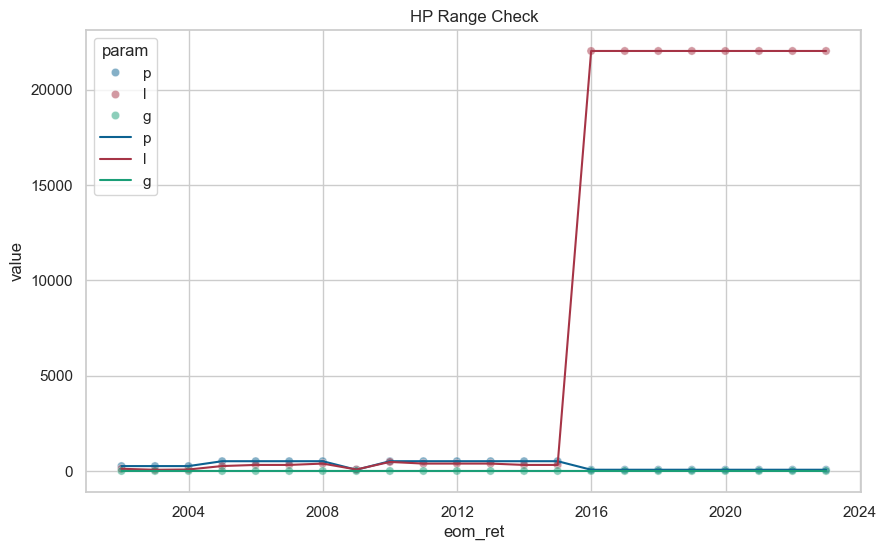

In [229]:
# (Optional: Create a diagnostic plot here – omitted or commented out)
# For example, using seaborn:
import seaborn as sns
import matplotlib.pyplot as plt
melt_df = best_hps.melt(id_vars=['eom_ret'], value_vars=['p', 'l', 'g'], var_name='param', value_name='value')
plt.figure(figsize=(10,6))
sns.scatterplot(data=melt_df, x='eom_ret', y='value', hue='param', alpha=0.5)
sns.lineplot(data=melt_df, x='eom_ret', y='value', hue='param')
plt.title("HP Range Check")
plt.show()

In [232]:
best_hps_list = {}
for d in dates_oos:
    d_ret = d + pd.offsets.MonthEnd(1)  # last day of next month
    oos_year = d_ret.year
    print("Processing aim portfolio for date:", d)
    # Filter best_hps for rows with hp_end equal to oos_year - 1
    best_hps_d = best_hps[best_hps['hp_end'] == (oos_year - 1)]
    if best_hps_d.empty:
        print(f"No best_hps found for year {oos_year-1}")
        continue
    best_row = best_hps_d.iloc[0]
    best_g = best_row['g']
    best_p = best_row['p']
    d_str = d.strftime('%Y-%m-%d')
    print("d_str",d_str)
    if str(best_g) not in hps or d_str not in hps[str(best_g)]["aim_pfs_list"]:
        print(f"No aim portfolio found for date {d_str} under best_g {best_g}")
        continue
    best_aim = hps[str(best_g)]["aim_pfs_list"][d_str]["aim_pf"]
    best_coef = hps[str(best_g)]["aim_pfs_list"][d_str]["coef"]
    best_hps_list[d_str] = {"g": best_g, "p": best_p, "aim": best_aim, "coef": best_coef}

if len(best_hps_list) == 0:
    raise ValueError("No aim portfolios were generated!")
    
    aims_df = pd.concat([entry["aim"] for entry in best_hps_list.values()], ignore_index=True)
    
    # Final portfolio: select data_tc for dates in dates_oos and valid == True, then call pfml_w.
    w_data = data_tc[(data_tc['valid'] == True) & (data_tc['eom'].isin(dates_oos))]
    w_data = w_data[['id', 'eom', 'eom_ret', 'me', 'tr_ld1', 'valid']]
    w = pfml_w(w_data, dates=dates_oos, cov_list=cov_list, lambda_list=lambda_list, gamma_rel=gamma_rel, iter=iter, risk_free=risk_free, wealth=wealth, mu=mu, aims=aims_df)
    pf = pf_ts_fun(w, data=data_tc, wealth=wealth, gam=gamma_rel)
    pf['type'] = "Portfolio-ML"
    rff_w_list = {g: hps[str(g)]["rff_w"] for g in g_vec}

Processing aim portfolio for date: 2010-12-31 00:00:00
d_str 2010-12-31
Processing aim portfolio for date: 2011-01-31 00:00:00
d_str 2011-01-31
Processing aim portfolio for date: 2011-02-28 00:00:00
d_str 2011-02-28
Processing aim portfolio for date: 2011-03-31 00:00:00
d_str 2011-03-31
Processing aim portfolio for date: 2011-04-30 00:00:00
d_str 2011-04-30
Processing aim portfolio for date: 2011-05-31 00:00:00
d_str 2011-05-31
Processing aim portfolio for date: 2011-06-30 00:00:00
d_str 2011-06-30
Processing aim portfolio for date: 2011-07-31 00:00:00
d_str 2011-07-31
Processing aim portfolio for date: 2011-08-31 00:00:00
d_str 2011-08-31
Processing aim portfolio for date: 2011-09-30 00:00:00
d_str 2011-09-30
Processing aim portfolio for date: 2011-10-31 00:00:00
d_str 2011-10-31
Processing aim portfolio for date: 2011-11-30 00:00:00
d_str 2011-11-30
Processing aim portfolio for date: 2011-12-31 00:00:00
d_str 2011-12-31
Processing aim portfolio for date: 2012-01-31 00:00:00
d_str 201

In [220]:
type(hps)

dict

In [203]:
pfml_input1 = copy.deepcopy(pfml_input)

In [180]:
feat_all = pfml_feat_fun(p=max(settings['pf_ml']['p_vec']), orig_feat=settings['pf_ml']['orig_feat'])
feat_indices = [feat_all.index(f) for f in feat_all if f in feat_all]


In [206]:
feat_all1 = copy.deepcopy(feat_all) 

In [207]:
type(feat_all1)

list

In [208]:
type(feat_all)

list

In [210]:
pfml_hp_coef = pfml_search_coef(
    pfml_input2, 
    p_vec=settings['pf_ml']['p_vec'], 
    l_vec=settings['pf_ml']['l_vec'], 
    hp_years=hp_years, 
    orig_feat=settings['pf_ml']['orig_feat']
)

In [211]:
validation = pfml_hp_reals_fun(
    pfml_input2, 
    hp_coef=pfml_hp_coef, 
    p_vec=settings['pf_ml']['p_vec'], 
    l_vec=settings['pf_ml']['l_vec'], 
    hp_years=hp_years, 
    orig_feat=settings['pf_ml']['orig_feat'],
)

In [217]:
for keys in validation.keys():
    print(keys)

eom
eom_ret
obj
l
p
hp_end
cum_obj
rank


In [212]:
aims = pfml_aims_fun(
    pfml_input2, 
    validation=validation, 
    data_tc=chars, 
    hp_coef=pfml_hp_coef, 
    hp_years=hp_years, 
    dates_oos=dates_oos, 
    l_vec=settings['pf_ml']['l_vec'], 
    orig_feat=settings['pf_ml']['orig_feat'],
)

In [162]:
def pfml_aims_fun(pfml_input, validation, data_tc, hp_coef, hp_years, dates_oos, l_vec, orig_feat):

    validation = validation.copy()
    validation['hp_end'] = validation['eom_ret'].dt.year
    # Filter opt_hps
    opt_hps = validation[(validation['eom_ret'].dt.month == 12) & (validation['rank'] == 1)][['hp_end', 'l', 'p']]
    
    aim_pfs_list = {}
    
    for d in dates_oos:
        # d_ret: "realiserende" dato – i R: d + 1 + months(1) - 1, dvs. sidste dag i næste måned
        d_ret = d + pd.offsets.MonthEnd(1)
        oos_year = d_ret.year
        hp_year = oos_year - 1
        
        # Filtrér opt_hps for rækker med hp_end == hp_year
        hps_d = opt_hps[opt_hps['hp_end'] == hp_year]
        if hps_d.empty:
            continue  # Ingen optimal hp for dette år, spring denne dato over
        
        # Forvent, at der kun er én række; hent p og l
        p_val = hps_d['p'].iloc[0]
        l_val = hps_d['l'].iloc[0]
    
        feat = pfml_feat_fun(p=p_val, orig_feat=orig_feat)
    
    
        d_key = d.strftime('%Y-%m-%d')
        s = pfml_input["signal_t"].get(d_key, None)
        if s is None:
            print(f"Ingen signal fundet for dato {d_key}")
            continue
        feat_indices = [feat.index(f) for f in feat if f in feat]
        #feat_indices = [feat_p.index(f) for f in feat_p if f in feat_p]
        s = s[:, feat_indices]
      #  print("s.shape", s.shape)
        try:
            l_no = next(i for i, val in enumerate(l_vec) if np.isclose(val, l_val))
        except StopIteration:
            print(f"Kunne ikke finde l={l_val} i l_vec for dato {d_key}")
            continue
    
        l_key = str(l_vec[l_no])  # potentiel fejl
        coef = hp_coef.get(str(oos_year), {}).get(str(p_val), {}).get(l_key) # potentiel fejl
     #   print("coef shape", coef.shape)
        # Filtrér data_tc for observationer, hvor valid==True og eom==d_key.
        aim_pf = data_tc[(data_tc['valid'] == True) & (data_tc['eom'] == d_key)][['id', 'eom']].copy()
    
        w_aim = (s @ coef).flatten()
        aim_pf['w_aim'] = w_aim
        
        # Gem resultatet for denne dato i aim_pfs_list.
        aim_pfs_list[d_key] = {"aim_pf": aim_pf, "coef": coef}

    
    return aim_pfs_list


In [158]:
feat_indices = [feat.index(f) for f in feat if f in feat]

In [121]:
validation = validation.copy()
validation['hp_end'] = validation['eom_ret'].dt.year
# Filter opt_hps
opt_hps = validation[(validation['eom_ret'].dt.month == 12) & (validation['rank'] == 1)][['hp_end', 'l', 'p']]

aim_pfs_list = {}

for d in dates_oos:
    # d_ret: "realiserende" dato – i R: d + 1 + months(1) - 1, dvs. sidste dag i næste måned
    d_ret = d + pd.offsets.MonthEnd(1)
    oos_year = d_ret.year
    hp_year = oos_year - 1
    
    # Filtrér opt_hps for rækker med hp_end == hp_year
    hps_d = opt_hps[opt_hps['hp_end'] == hp_year]
    if hps_d.empty:
        continue  # Ingen optimal hp for dette år, spring denne dato over
    
    # Forvent, at der kun er én række; hent p og l
    p_val = hps_d['p'].iloc[0]
    l_val = hps_d['l'].iloc[0]

    feat = pfml_feat_fun(p=p_val, orig_feat=orig_feat)


    d_key = d.strftime('%Y-%m-%d')
    s = pfml_input["signal_t"].get(d_key, None)
    if s is None:
        print(f"Ingen signal fundet for dato {d_key}")
        continue

    feat_indices = [feat_p.index(f) for f in feat_p if f in feat_p]
    s = s[:, feat_indices]

    try:
        l_no = next(i for i, val in enumerate(l_vec) if np.isclose(val, l_val))
    except StopIteration:
        print(f"Kunne ikke finde l={l_val} i l_vec for dato {d_key}")
        continue

    l_key = str(l_vec[l_no])  # potentiel fejl
    coef = hp_coef.get(str(oos_year), {}).get(str(p_val), {}).get(l_key) # potentiel fejl
    # Filtrér data_tc for observationer, hvor valid==True og eom==d_key.
    aim_pf = data_tc[(data_tc['valid'] == True) & (data_tc['eom'] == d_key)][['id', 'eom']].copy()

    w_aim = (s @ coef).flatten()
    aim_pf['w_aim'] = w_aim
    
    # Gem resultatet for denne dato i aim_pfs_list.
    aim_pfs_list[d_key] = {"aim_pf": aim_pf, "coef": coef}


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [125]:
l_no

100

In [124]:
hps_d["l"]

154895    387.453546
Name: l, dtype: float64

In [110]:
print(s.shape)
print(coef.shape)

(180, 513)
(65,)


In [111]:
aim_pf.shape

(180, 2)

In [119]:
hps_d

,hp_end,l,p
98171,2021,22026.465795,64


In [117]:
s.shape

(180, 513)

In [118]:
coef.shape

(65,)

In [106]:
aim_pf

,id,eom
431,10104,2022-11-30
863,10107,2022-11-30
1291,10138,2022-11-30
1716,10696,2022-11-30
2196,11308,2022-11-30
...,...,...
71850,87299,2022-11-30
72117,87432,2022-11-30
72385,87447,2022-11-30
72793,87717,2022-11-30


In [ ]:
    aim_pf = data_tc[(data_tc['valid'] == True) & (data_tc['eom'] == d_key)][['id', 'eom']].copy()
    # Beregn w_aim = s @ coef, og fjern unødvendige dimensioner.
    w_aim = (s @ coef).flatten()
    aim_pf['w_aim'] = w_aim
    
    # Gem resultatet for denne dato i aim_pfs_list.
    aim_pfs_list[d_key] = {"aim_pf": aim_pf, "coef": coef}

In [ ]:
# Først: fra validation udvælges de optimale hp-værdier,
# dvs. de rækker hvor eom_ret har måned 12 og rank == 1.
# Vi opretter også en kolonne 'hp_end' som året for eom_ret.
validation = validation.copy()
validation['hp_end'] = validation['eom_ret'].dt.year
# Filter opt_hps
opt_hps = validation[(validation['eom_ret'].dt.month == 12) & (validation['rank'] == 1)][['hp_end', 'l', 'p']]

aim_pfs_list = {}

# For hver dato i dates_oos:
for d in dates_oos:
    # d_ret: "realiserende" dato – i R: d + 1 + months(1) - 1, dvs. sidste dag i næste måned
    d_ret = d + pd.offsets.MonthEnd(1)
    oos_year = d_ret.year
    hp_year = oos_year - 1
    
    # Filtrér opt_hps for rækker med hp_end == hp_year
    hps_d = opt_hps[opt_hps['hp_end'] == hp_year]
    if hps_d.empty:
        continue  # Ingen optimal hp for dette år, spring denne dato over
    
    # Forvent, at der kun er én række; hent p og l
    p_val = hps_d['p'].iloc[0]
    l_val = hps_d['l'].iloc[0]
    
    # Få de ønskede feature-indekser via pfml_feat_fun
    feat = pfml_feat_fun(p=p_val, orig_feat=orig_feat)
    
    # Hent signalmatrix for datoen d fra pfml_input["signal_t"].
    # Antag at nøglerne er i formatet "YYYY-MM-DD".
    d_key = d.strftime('%Y-%m-%d')
    s = pfml_input["signal_t"].get(d_key, None)
    if s is None:
        print(f"Ingen signal fundet for dato {d_key}")
        continue
    # Vælg de kolonner, der svarer til feat:
    s = s[:, feat]
    
    # Find positionen for l_val i l_vec; brug np.isclose for at undgå floating point fejl.
    try:
        l_no = next(i for i, val in enumerate(l_vec) if np.isclose(val, l_val))
    except StopIteration:
        print(f"Kunne ikke finde l={l_val} i l_vec for dato {d_key}")
        continue
    
    # Hent koefficienterne fra hp_coef for det aktuelle oos_year, p_val og l_no.
    # hp_coef forventes at have nøgler som str(oos_year) og str(p_val)
    coef = hp_coef.get(str(oos_year), {}).get(str(p_val), [])[l_no]
    
    # Filtrér data_tc for observationer, hvor valid==True og eom==d_key.
    aim_pf = data_tc[(data_tc['valid'] == True) & (data_tc['eom'] == d_key)][['id', 'eom']].copy()
    # Beregn w_aim = s @ coef, og fjern unødvendige dimensioner.
    w_aim = (s @ coef).flatten()
    aim_pf['w_aim'] = w_aim
    
    # Gem resultatet for denne dato i aim_pfs_list.
    aim_pfs_list[d_key] = {"aim_pf": aim_pf, "coef": coef}

In [70]:

for end in hp_years:
    # Definer intervallet: fra (end-1)-12-31 til end-11-30
    lower_bound = pd.to_datetime(f"{end-1}-12-31")
    upper_bound = pd.to_datetime(f"{end}-11-30")
    # Filter pfml_input["reals"] til de datoer i dette interval
    reals_all = {k: v for k, v in reals_all_all.items() if lower_bound <= k <= upper_bound}
    # Hent koefficientlisten for dette år
    coef_list_yr = hp_coef[str(end)]
    
    # For hver p i p_vec
    p_dfs = []
    for p in p_vec:
        # Få de relevante features via pfml_feat_fun (forventet at returnere en liste af indekser)
        feat_p = pfml_feat_fun(p=p, orig_feat=orig_feat)
        # Hent koefficientlisten for denne p
        coef_list_p = coef_list_yr[str(p)]
        # For hver observation i reals_all skal vi vælge de features, der svarer til feat_p:
        feat_indices = [feat_p.index(f) for f in feat_p if f in feat_p]
        reals = {
            k: {
                "r_tilde": np.array(v["r_tilde"])[feat_indices],
                "denom": np.array(v["denom"])[np.ix_(feat_indices, feat_indices)]
            }
            for k, v in reals_all.items()
        }
        
        # For hver l-værdi (brug i indeks i l_vec)
        l_dfs = []
        for l_val in l_vec:
            coef = coef_list_p[str(l_val)]
            rows = []
            # For hver dato (nm) i reals (nøglerne)
            for nm, x in reals.items():
                # Beregn r = t(x$r_tilde) %*% coef - 0.5 * t(coef) %*% x$denom %*% coef
                r_val = np.dot(x["r_tilde"].T, coef) - 0.5 * np.dot(np.dot(coef.T, x["denom"]), coef)
                # Hvis r_val er skalar, konverter til float
                if np.isscalar(r_val):
                    r_val = float(r_val)
                # Opret række med:
                #   eom: datoen (konverteret til Timestamp)
                #   eom_ret: eom + 1 måned (som i R: as.Date(nm) + months(1))
                #   obj: r_val
                #   l: den aktuelle l-værdi
                row = {
                    "eom": pd.to_datetime(nm),
                    "eom_ret": pd.to_datetime(nm) + pd.DateOffset(months=1),
                    "obj": r_val,
                    "l": l_val
                }
                rows.append(row)
            # Opret en DataFrame for denne l-værdi
            df_l = pd.DataFrame(rows)
            l_dfs.append(df_l)
        # Kombinér over l_vec og tilføj p-kolonnen
        df_p = pd.concat(l_dfs, ignore_index=True)
        df_p["p"] = p
        p_dfs.append(df_p)
    # Kombinér over p_vec og tilføj hp_end-kolonnen
    df_end = pd.concat(p_dfs, ignore_index=True)
    df_end["hp_end"] = end
    validation_dfs.append(df_end)

# Kombinér over alle hp_years
validation = pd.concat(validation_dfs, ignore_index=True)

# Sortér efter p, l, eom_ret
validation = validation.sort_values(by=["p", "l", "eom_ret"])
# Beregn kumulativ middelværdi (cum_obj) for hver gruppe (p, l)
validation["cum_obj"] = validation.groupby(["p", "l"])["obj"].transform(lambda x: x.expanding().mean())
# Beregn rangeringen af -cum_obj inden for hver eom_ret-gruppe
validation["rank"] = validation.groupby("eom_ret")["cum_obj"].rank(ascending=False, method="min")

In [269]:
validation

,eom,eom_ret,obj,l,p,hp_end,cum_obj,rank,g
0,2000-12-31,2001-01-31,0.000668,0.000000,64,2001,0.000668,1012.0,0.135335
106656,2000-12-31,2001-01-31,0.000668,0.000000,64,2001,0.000668,1012.0,0.135335
213312,2000-12-31,2001-01-31,0.000668,0.000000,64,2001,0.000668,1012.0,0.135335
319968,2000-12-31,2001-01-31,0.000668,0.000000,64,2001,0.000668,1012.0,0.135335
426624,2000-12-31,2001-01-31,0.000668,0.000000,64,2001,0.000668,1012.0,0.135335
...,...,...,...,...,...,...,...,...,...
319967,2022-11-30,2022-12-30,-0.000783,22026.465795,512,2022,-0.001651,145.0,0.135335
426623,2022-11-30,2022-12-30,-0.000783,22026.465795,512,2022,-0.001650,144.0,0.135335
533279,2022-11-30,2022-12-30,-0.000783,22026.465795,512,2022,-0.001650,143.0,0.135335
639935,2022-11-30,2022-12-30,-0.000783,22026.465795,512,2022,-0.001649,142.0,0.135335


In [123]:
feat_p_test=pfml_feat_fun(p=64, orig_feat=orig_feat)
feat_indices = [feat_p_test.index(f) for f in feat_p if f in feat_p_test]
r_tilde_sub_test = r_tilde_sum[feat_indices] / n
denom_sub = denom_raw_sum.to_numpy()[np.ix_(feat_indices, feat_indices)] / n